# Integrated Approach (IA) for modeling TRM flow cytometry timeseries

**Notebook for analysing the CD4 data**

Use neural networks to cluster the data and fit a dynamical model at the same time.

1. Use a VAE to produce a dimension reduction of the data
2. add a GMM prior to the latent space
3. Add time information and an ODE model

## Required data

This notebook makes use of parsed and annotated data that was saved in the `SequentialApproachClusCD4.ipynb` notebook.
In addition, we use the cell counts.

## Content of notebook

* Import and parse data
* Fit simple model to only the cell count data (as a demonstration)
* Fit full model to data, or load a pre-trained model
* Inspect model fit and prepare data for figure
* Do model validation analyses

## Using a script to fit the model

The `scdynsys` package contains a python script `fit_vae.py` which is added to the path (as `fit_vae`).
This script can be used to fit the model in a non-interactive environment (e.g. a HPC cluster).
We also provided a bash script `fit-vae-CD4.sh` with typical command-line arguments.

In [1]:
import os
import csv
import pickle
import json
import collections
import numpy as np
import torch
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib.lines
from scipy.stats import gaussian_kde
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from tqdm.notebook import trange
import matplotlib.colors as mcolors
import itertools
from pyro.infer import Predictive

import scdynsys.vae.gmmdyn
import scdynsys.vae.dyn
from scdynsys.vae.utils import (
    train, onehot_encoding, train_test_loop_full_dataset, compute_ppd_freqs
)
from scdynsys import plots, stats
from scdynsys import utilities
from scdynsys.projection import umap_embedding, apply_umap
from scdynsys.vae.gmmdyn import cluster_distance_matrix


# colors for clusters

tabcolors =  [matplotlib.colors.to_hex(plt.cm.tab20(i/20)) for i in range(20)]
tabcolors = [tabcolors[2*i] for i in range(10)] + [tabcolors[2*i+1] for i in range(10)]

clus_color_dict = dict(zip(range(20), itertools.cycle(tabcolors)))

pyro.set_rng_seed(156756)

### Load the prepared data set

Dataset created (and used) in `SequentialApproachClusCD4.ipynb` notebook

In [2]:
## load a prepared data set

expr_data_file = "../data/pyro-dataset-CD4-conv-Lung-Aug23.csv"
metadata_file = "../data/pyro-dataset-meta-CD4-conv-Lung-Aug23.csv"
selected_marker_file = "../data/selected-markers-CD4-conv-Aug23.json"

## import marker expression data
with open(expr_data_file) as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    raw_data_ext = np.array([row for row in reader], dtype=np.float32)

print("column names", " ".join(header))
print("example rows:\n", raw_data_ext[:2])

## load selected markers
with open(selected_marker_file, 'r') as f:
    sel_markers = json.load(f)
    
print("selected markers: ", sel_markers)

sel_markers_ext = header ## all markers in the data file
raw_data = raw_data_ext[:, [header.index(m) for m in sel_markers]]

with open(metadata_file, 'r') as f:
    raw_metadata = [x for x in csv.reader(f)]
    metadata_varnames = raw_metadata[0]
    raw_metadata = np.array(raw_metadata[1:])

print("metadata:", " ".join(metadata_varnames))

# make sure that the marker and meta data have the same number of cells
assert raw_data.shape[0] == raw_metadata.shape[0], "data and metadata have incompatible length"

# subsample for fast testing/development
print("shape of full dataset", raw_data.shape)

column names CD49a CD103 CD69 CXCR6 PD1 Klrg1 CD62L Bcl2 CD27 FR4 CX3CR1 CXCR5 Ki67 CD4_NP
example rows:
 [[-1.1408472  -0.71854216 -1.3148943  -0.17066167 -2.0853882  -0.03172564
   0.02788024  2.4076984  -1.2167752  -0.8812136   0.80999655 -0.54774094
  -0.24790645 -0.5754383 ]
 [ 0.3821336  -0.30379814  1.0944577   0.37673736 -1.230634   -0.7287108
   0.34437492 -0.07042816 -1.2018843  -0.82737756  0.4658922  -0.0121262
  -1.5556883  -0.01590748]]
selected markers:  ['CD69', 'CD103', 'CD49a', 'CXCR6', 'PD1', 'Klrg1', 'CD62L', 'CD27', 'Bcl2', 'FR4']
metadata: batch day CM Eff Tet+
shape of full dataset (465681, 10)


### Make a test/train/validate split

The test data is used to check that we're not overfitting.
Overfitting would lead to a decrease in the train ELBO trace, while the test ELBO reaches a minimum and starts to increase.
With all tested models, this never happens.

At this point, we are not using the "validation" data set. We want to use this to e.g. compare models using out-of-sample data.

In [3]:
# sample validation data and test/train data
num_validate = 10000
num_test_train = 100000
idxs_validate = np.random.choice(raw_data.shape[0], num_validate, replace=False)
# avoid validation indices in test-train loops
idxs_no_validate = [i for i in range(raw_data.shape[0]) if i not in idxs_validate]
idxs_test_train = np.random.choice(idxs_no_validate, num_test_train, replace=False) ## SUBSAMPLING!!!

validation_data = raw_data[idxs_validate, :]
validation_metadata = raw_metadata[idxs_validate, :]

assert len(set(idxs_test_train).intersection(set(idxs_validate))) == 0, "validation and test/train set overlap"
    
raw_data = raw_data[idxs_test_train, :]
raw_metadata = raw_metadata[idxs_test_train, :]

num_samples, feature_dim = raw_data.shape
num_test = 10000
num_train = num_samples - num_test

## metadata...
raw_batch = raw_metadata[:,0]
unique_batch = sorted(list(set(raw_batch)))
num_batch = len(unique_batch)

print("number of batches:", num_batch)

sample_day = np.array(raw_metadata[:,1], dtype=np.float32)
unique_sample_day = sorted(list(set(sample_day)))
num_sample_day = len(unique_sample_day)

print("number of sample days:", num_sample_day)

## map batch to day and experiment
batch_day_dict = dict(zip(raw_metadata[:,0], map(int, raw_metadata[:,1])))

number of batches: 27
number of sample days: 8


### Show a UMAP of the marker expression data

doing UMAP
doing KDE


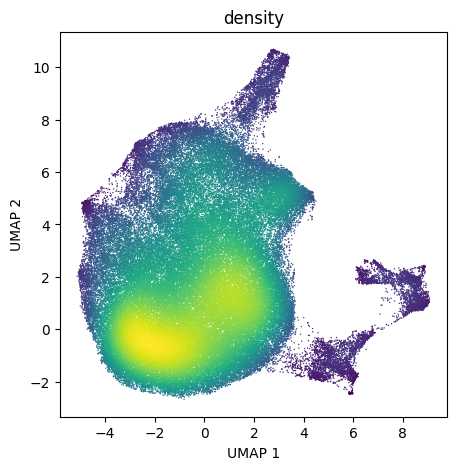

In [4]:
print("doing UMAP")
umap_data, umapper = umap_embedding(raw_data, dim=2)

print("doing KDE")
ran_idxs = np.random.choice(num_samples, min(num_samples, 1000), replace=False)
col_dens = sts.gaussian_kde(umap_data[ran_idxs, :].T)(umap_data.T)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(umap_data[:,0], umap_data[:,1], s=1, c=col_dens, linewidths=0)
ax.set_title("density")
ax.set(xlabel="UMAP 1", ylabel="UMAP 2");

### We could integrate data from multiple experiments. In this analysis, we only use a single expt.

The batch correction layer can take multiple batch levels into account. For instance animal and experiment.
This is done by combining one-hot encoded vectors with different weights. For instance, 
the batch effect between animals is expected to be small compared to an experiment-specific batch effect.

In [5]:
unique_expt = ['0']
raw_expt = np.array(['0' for _ in raw_batch])
num_expt = 1

# use the batch with the largest number of samples as a reference

num_samples_per_batch = collections.Counter(raw_batch)
batch_ref = max(num_samples_per_batch, key=lambda x: num_samples_per_batch[x])

print("choosing reference batch ID:", batch_ref)

num_samples_per_expt = collections.Counter(raw_expt)
expt_ref = max(num_samples_per_expt, key=lambda x: num_samples_per_expt[x])

print("choosing reference expt ID:", expt_ref)

choosing reference batch ID: 16
choosing reference expt ID: 0


In [6]:
batch_expt_onehot, batch_onehot, expt_onehot = onehot_encoding(
    unique_batch, raw_batch, unique_expt, raw_expt, 0.1, batch_ref=batch_ref, expt_ref=expt_ref
)

print(expt_onehot.shape, batch_onehot.shape)

print("example:\n", batch_expt_onehot[0])

## test and train indices for the dataloader-free method
test_indices = np.random.choice(raw_data.shape[0], num_test, replace=False)
train_indices = [i for i in range(raw_data.shape[0]) if i not in test_indices]

(100000, 0) (100000, 26)
example:
 [0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0. ]


## Import cell counts

These are the same cell counts that we used in the SA. Make sure to exclude bad data points.

problematic mice (excluded) [7, 17, 19, 25, 27, 32, 33, 35]


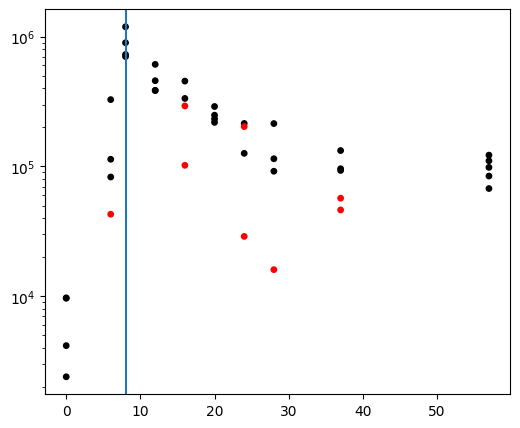

In [7]:
## make sure we start at the right day
T0 = 8.0

cell_count_file = f"../data/CD4_counts_Aug23.pkl"

with open(cell_count_file, 'rb') as f:
    cell_counts = pickle.load(f)
    
days = cell_counts["DPI"]
Ns = cell_counts["CD44+CD11a+_CD4_Tconv"]
IDs = cell_counts["ID"]
include_mice = cell_counts["include"]
problem_mice = [ID for incl, ID in zip(include_mice, IDs) if not incl]

print("problematic mice (excluded)", problem_mice)

scaling = 1e6

raw_count_data_combined = [
    (t-T0, x / scaling) 
    for t, x, ID in zip(days, Ns, IDs) 
    if t >= T0 and ID not in problem_mice
]

raw_count_data_combined.sort()

fig, ax = plt.subplots(1, 1, figsize=(6,5))
col = ['k' if ID not in problem_mice else 'r' for ID in IDs]
ax.scatter(days, Ns, c=col, s=15, zorder=1)
ax.set_yscale('log')

ax.axvline(x=T0)

## create tensors (no need for data loaders)
ydata_raw = np.array([y[1] for y in raw_count_data_combined], dtype=np.float32)
ydata_tensor = torch.tensor(ydata_raw, dtype=torch.float32)
ytime_raw = np.array([y[0] for y in raw_count_data_combined], dtype=np.float32)
ytime_tensor = torch.tensor(ytime_raw, dtype=torch.float32)

## Fit simplfied model only to the cell counts

In the `scdynsys` package we defined a module called `simpledyn` which can be used to fit models to the cell count data. Compare this with the `counts_only.stan` model used in the `BiphasicModels.ipynb` notebook.

This is just for testing and getting a grip on the method.

initial loss:  12.707815551757813


  0%|          | 0/1000 [00:00<?, ?it/s]

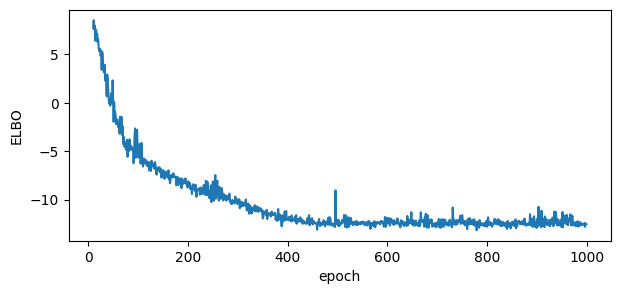

In [8]:
from pyro.infer.autoguide.initialization import init_to_mean, init_to_value
import scdynsys.vae.simpledyn

pyro.set_rng_seed(1876)

# clear param store
pyro.clear_param_store()


## init for inhom model
num_clus = 1
init_dict_dyn = {
    "loc_rho" : torch.tensor(-0.05),
    "scale_rho" : torch.tensor(0.01),
    "loc_eta" : torch.tensor(-0.05),
    "scale_eta" : torch.tensor(0.01),
    "logX0" : torch.full((num_clus,), 0.0 - np.log(num_clus)),
    "u" : torch.tensor(0.1)
}

## init for hom model
init_dict_dyn_hom = {
    "loc_rho" : torch.tensor(-0.09),
    "scale_rho" : torch.tensor(0.01),
    "logX0" : torch.full((num_clus,), 0.2 - np.log(num_clus)),
}


init_fn = init_to_value(values=init_dict_dyn, fallback=init_to_mean)
dyn = scdynsys.vae.dyn.DynamicModel(num_clus, hom=True, init_fn=init_fn, init_scale=0.01)
mod = scdynsys.vae.simpledyn.EncapsulatedDyn(num_clus, dyn)


# Run options
LEARNING_RATE = 1e-2

NUM_EPOCHS = 1000

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)
loss_method = Trace_ELBO(num_particles=10, vectorize_particles=True)

# setup the inference algorithm
svi = SVI(mod.model, mod.guide, optimizer, loss=loss_method)

print("initial loss: ", svi.evaluate_loss(ydata_tensor, ytime_tensor))

train_elbo = []
# training loop
for epoch in (pbar := trange(NUM_EPOCHS)):
    loss = svi.step(ydata_tensor, ytime_tensor)
    train_elbo.append((epoch, loss))
    pbar.set_description(f"average train loss: {loss:0.2f}")
        

## Check out convergence of the optimizer
    
fig, ax = plt.subplots(1, 1, figsize=(7,3))

burnin = 10
ax.plot([x[0] for x in train_elbo[burnin:]], [x[1] for x in train_elbo[burnin:]])
ax.set_ylabel("ELBO")
ax.set_xlabel("epoch");

### Plot the timeseries and fitted model

For this, we use the `Predictive` class from Pyro. 

Text(0.5, 0, 'DPI')

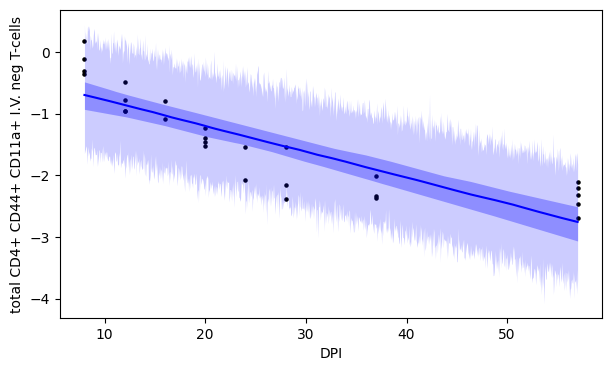

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.scatter(
    np.array([x[0]+T0 for x in raw_count_data_combined]),
    np.log(np.array([x[1] for x in raw_count_data_combined])),
    s=5, color='k'
)

ts_raw = np.linspace(0, max(days)-T0, 1000, dtype=np.float32)
ts_tensor = torch.tensor(ts_raw)

## use pyro's built-in Predictive class

predictive = Predictive(
    mod.model, guide=mod.guide, num_samples=100, 
    return_sites=[
        "_RETURN", "loc_rho", "scale_rho", 
        "rho", "loc_eta", "scale_eta", 
        "eta", "logX0", "yobs", "y_scale", "u"
    ]
)
sams = predictive(None, ts_tensor)
yshats = sams["_RETURN"]
yhats_raw = yshats.detach().numpy()
yhats_low, yhats_med, yhats_hi = np.percentile(yhats_raw, q=[2.5, 50, 97.5], axis=0)

ys_scale = sams["y_scale"]
y_scale_raw = ys_scale.detach().numpy()
y_scale_med = np.median(y_scale_raw)


yobs = sams["yobs"]
yobs_raw = np.log(yobs.detach().numpy())
yobs_low, yobs_med, yobs_hi = np.percentile(yobs_raw, q=[2.5, 50, 97.5], axis=0)

ax.plot(ts_raw+T0, yhats_med, color='b')
ax.fill_between(ts_raw+T0, yhats_low, yhats_hi, alpha=0.3, color='b', linewidth=0)
ax.fill_between(ts_raw+T0, yobs_low, yobs_hi, alpha=0.2, color='b', linewidth=0)
    
## titles etc
ax.set_ylabel(f"total CD4+ CD44+ CD11a+ I.V. neg T-cells")

ax.set_xlabel("DPI")

### Use estimates from the "simple model" as initial guesses for the full model

We use initial population size, loss rates and change in loss rate to get a better initial guess for the full model.

We found that using good initial guesses can really speed up convergence!

In [10]:
## print some values to get good initial guesses

sams_loc_rho = sams["loc_rho"].squeeze().detach().numpy()
print("loc_rho:", np.mean(sams_loc_rho))


sams_logX0 = sams["logX0"].squeeze().detach().numpy()
print("logX0:", np.mean(sams_logX0))

if "loc_eta" in sams:
    sams_loc_eta = sams["loc_eta"].squeeze().detach().numpy()
    print("loc_eta:", np.mean(sams_loc_eta))

if "u" in sams:
    sams_u = sams["u"].squeeze().detach().numpy()
    print("u:", np.mean(sams_u))

loc_rho: -0.04214948
logX0: -0.6938079


## Fit full model to both cell counts and flow data

To fit the model, we can either use this notebook (good for testing, development, smoke tests)
or we can use the provided script `fit_vae.py`. This script is available in the path
if `scdynsys` is installed with `pip`. We also provided a bash script with command line
arguments to fit run the `fit_vae.py` script.

We first have to convert some data to `pytorch` tensors. Notice that we have many data points (single cells) that each have a sampling time.
However, we do not have to solve the ODE model at each of these times separately. That would be very wastefull.
The number of unique time points is very small. Therefore we make tensors with indices mapping cells to time points in a shorter unique time tensor.

In [11]:
xtime_raw = sample_day-T0
xtime_tensor = torch.tensor(xtime_raw, dtype=torch.float32)

utime_raw = np.unique(np.concatenate([xtime_raw, ytime_raw]))
utime_tensor = torch.tensor(utime_raw, dtype=torch.float32)
print("unique time points: ", utime_tensor)

## compute indices
xtime_index_raw = np.array([np.where(np.isclose(utime_raw, t))[0][0] for t in xtime_raw])
xtime_index_tensor = torch.tensor(xtime_index_raw)

assert all(xtime_tensor == utime_tensor[xtime_index_tensor]), "indexing of unique times fails"

ytime_index_raw = np.array([np.where(np.isclose(utime_raw, t))[0][0] for t in ytime_raw])
ytime_index_tensor = torch.tensor(ytime_index_raw)

assert all(ytime_tensor == utime_tensor[ytime_index_tensor]), "indexing of unique times fails"

unique time points:  tensor([ 0.,  4.,  8., 12., 16., 20., 29., 49.])


### Initialize the VAE object and dynamical model, set initial parameter guesses.

Also choose the learning rate, number of epochs, etc.

In [12]:
# Run options
LEARNING_RATE = 5e-3
USE_CUDA = True
NUM_EPOCHS = 1000
TEST_FREQUENCY = 1

# clear param store
pyro.clear_param_store()

## select device
device = torch.device("cuda" if USE_CUDA else "cpu")

# setup the VAE
num_clus = 12

init_dict_dyn_inhom = {
    "loc_rho" : torch.tensor(-0.05, device=device),
    "scale_rho" : torch.tensor(0.01, device=device),
    "loc_eta" : torch.tensor(-0.05, device=device),
    "scale_eta" : torch.tensor(0.01, device=device),
    "logX0" : torch.full((num_clus,), 0.0 - np.log(num_clus), device=device),
    "u" : torch.tensor(0.1, device=device),
    "loc_Q" : torch.tensor(0.001, device=device)
}

## init for hom model
init_dict_dyn_hom = {
    "loc_rho" : torch.tensor(-0.2, device=device),
    "scale_rho" : torch.tensor(0.01, device=device),
    "logX0" : torch.full((num_clus,), 1.0 - np.log(num_clus), device=device),
    "loc_Q" : torch.tensor(0.001, device=device)
}

init_dict_dyn = init_dict_dyn_inhom

init_fn = init_to_value(values=init_dict_dyn, fallback=init_to_mean)

dyn = scdynsys.vae.dyn.DynamicModelDiff(
    num_clus, hom=True, init_fn=init_fn, init_scale=0.01, 
    growth_rate_penalty=10, use_cuda=USE_CUDA
)

vae = scdynsys.vae.gmmdyn.VAEgmmdyn(
    data_dim=feature_dim, 
    z_dim=6,
    hidden_dim=20, 
    num_clus=num_clus,
    num_batch=batch_expt_onehot.shape[1],
    dyn=dyn,
    time_scale=0.01,
    reg_scale_batch=1.0,
    reg_scale=10.0,
    reg_norm="l2",
    fixed_scales=True,
    use_cuda=USE_CUDA
)

### Fit the VAE model

Run the following cell to fit the dynamical VAE model to the flow data nad cell counts.

<div class="alert alert-block alert-info"> <b>NOTE</b> 
    This step can be skipped if you want to use the pre-fitted Pyro model.
</div>

Make sure you have a GPU with enough VRAM. Development of these models was done on a **GeForce GTX 1080 Ti** with 11GB VRAM. 
This was plenty to fit the model, while also doing other video-intensive tasks. 
Fitting the model on a smaller **GeForce GTX 980 Ti**  with 6GB VRAM also works fine, but might fail of the 
graphics card is used for other tasks as well.

For larger datasets or smaller GPUs, some dataloader features are available in `scdynsys.vae.utils`

<div class="alert alert-block alert-warning"> <b>WARNING</b> 
    Fitting the VAE model takes a lot of time.
</div>

In [13]:
%%time

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)
loss_method = Trace_ELBO(num_particles=20, vectorize_particles=True)

svi = SVI(vae.model, vae.guide, optimizer, loss=loss_method)

raw_train_data = (
    raw_data[train_indices],
    xtime_index_raw[train_indices],
    batch_expt_onehot[train_indices]
)

raw_test_data = (
    raw_data[test_indices],
    xtime_index_raw[test_indices],
    batch_expt_onehot[test_indices]
)

raw_addl_data = (ydata_raw, ytime_index_raw, utime_raw)

train_elbo, test_elbo = train_test_loop_full_dataset(
    svi,
    raw_train_data,
    raw_test_data,
    NUM_EPOCHS,
    TEST_FREQUENCY,
    raw_addl_data=raw_addl_data,
    use_cuda=USE_CUDA,
    show_progress=True
)

test loss: 999320.55: 100%|██████████| 1000/1000 [08:50<00:00,  1.88it/s] 

CPU times: user 21min 22s, sys: 8.52 s, total: 21min 31s
Wall time: 8min 50s


### look at trace of the ELBO to assess convergence.

An increasing ELBO of the test data would indicate overfitting

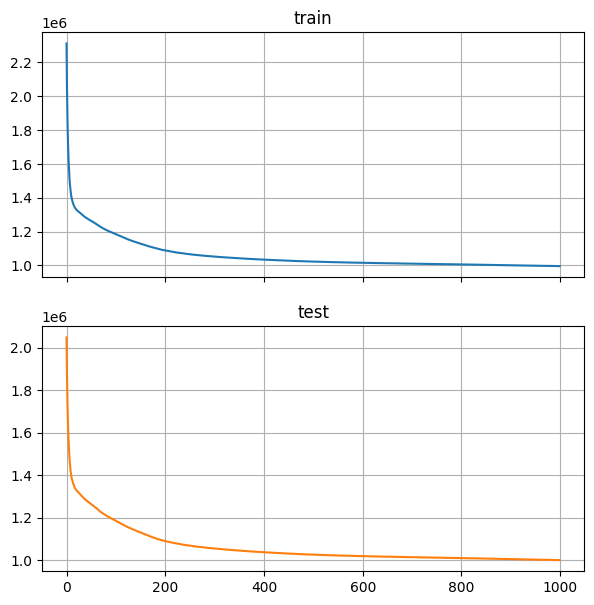

In [14]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7,7))

burnin = 0
axs[0].plot([x[0] for x in train_elbo[burnin:]], [x[1] for x in train_elbo[burnin:]], color='tab:blue')
burnin = 0
axs[1].plot([x[0] for x in test_elbo[burnin:]], [x[1] for x in test_elbo[burnin:]], color='tab:orange')

labels = ['train', 'test']
for i, ax in enumerate(axs):
    ax.grid()
    ax.set_title(labels[i])

## Import saved model fit

<div class="alert alert-block alert-info"> <b>NOTE</b> 
    Continue with the next cell if you want to use the pre-fitted model
</div>

To load a fitted model we need a file with the settings (a .json file) and a file  with the saved Pyro "parameter store" (.dat file)
The ELBO trace is saved in a Python pickle.

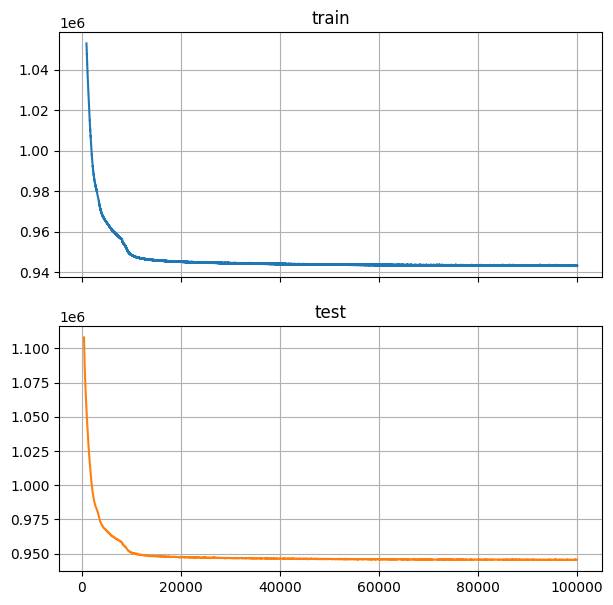

In [15]:
file_id = "CD4_modelIII_12clus"

pyro_model_dir = "../pyro-cache/"

settings_file = os.path.join(pyro_model_dir, f"settings_{file_id}.json")
loss_trace_file = os.path.join(pyro_model_dir, f"loss_trace_{file_id}.pkl")
param_file = os.path.join(pyro_model_dir, f"parameter_store_{file_id}.dat")

with open(settings_file, 'r') as f:
    settings = json.load(f)

grp = None if not settings["penalize_growth"] else settings["growth_rate_penalty"]
Mod = scdynsys.vae.dyn.DynamicModelDiff if settings["diff"] else scdynsys.vae.dyn.DynamicModel
dyn = Mod(
    settings["num_clus"], hom=settings["hom"], 
    growth_rate_penalty=grp, use_cuda=USE_CUDA,
    numeric_solver=settings["numeric_solver"], 
)

## setup the VAE model
vae = scdynsys.vae.gmmdyn.VAEgmmdyn(
    data_dim=settings["data_dim"], 
    z_dim=settings["z_dim"],
    hidden_dim=settings["hidden_dim"], 
    num_clus=settings["num_clus"],
    num_batch=settings["num_batch"],
    dyn=dyn,
    reg_scale=settings["reg_scale"],
    reg_scale_batch=settings["reg_scale_batch"],
    time_scale=settings["time_scale"],
    reg_norm=settings["reg_norm"],
    fixed_scales=settings["fixed_scales"],
    distance_guided_diff=True,
    use_cuda=USE_CUDA
)

store = pyro.get_param_store()

store.clear()
store.load(param_file)
state_dict = vae.state_dict()
state_dict.update({k : store[k] for k in state_dict if k in store})
vae.load_state_dict(state_dict)

with open(loss_trace_file, 'rb') as f:
    loss_trace = pickle.load(f)
    
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7,7))

trace_labels = ["train", "test"]
trace_color_dict = {"train" : 'tab:blue', 'test' : 'tab:orange'}
burnin_dict = {"train" : 1000, 'test' : 10}

for i, k in enumerate(trace_labels):
    v = loss_trace[k]
    burnin = burnin_dict[k]
    axs[i].plot(
        [x[0] for x in v[burnin:]], 
        [x[1] for x in v[burnin:]], 
        label=k, color=trace_color_dict[k]
    )
    
for i, ax in enumerate(axs):
    ax.grid()
    ax.set_title(trace_labels[i])

### Apply UMAP to the latent space

To plot the results of the VAE embedding, we have to apply a dimension reduction algorithm to make a 2D plot.
We again use UMAP.

In [16]:
%%time
## checkout latent representation

tensor_data = torch.Tensor(raw_data).cuda()
tensor_batch_onehot = torch.Tensor(batch_expt_onehot).cuda()
tensor_latent = vae.dimension_reduction(tensor_data, xtime_tensor.cuda(), tensor_batch_onehot)
raw_latent = tensor_latent.cpu().detach().numpy()

raw_latent_umap, reducer = apply_umap(raw_latent)

doing UMAP...
CPU times: user 46min 46s, sys: 4min 59s, total: 51min 45s
Wall time: 1min 11s


### Cluster labels

before we assign meaningful phenotypes to the clusters (e.g. TRM 1, TEM 2, Teff), 
we use integers to label clusters. To be consistent (with Leiden clustering), 
we enumerate the clusters by size. We do this by sorting the VAE clusters by size in `clus_sorted_by_size`.

<div class="alert alert-block alert-warning"> <b>WARNING</b> 
    Some clusters have quite similar sizes, making their order dependent on randomly assigned clusters
    by `VAEgmmdyn.classifier`. To make sure consistent names and colors are used in the remainder
    of the notebooks, we use a fixed relabeling. <b>For your own fits, you might want to use the commented-out
    code to sort populations by size.</b>
</div>

doing KDE


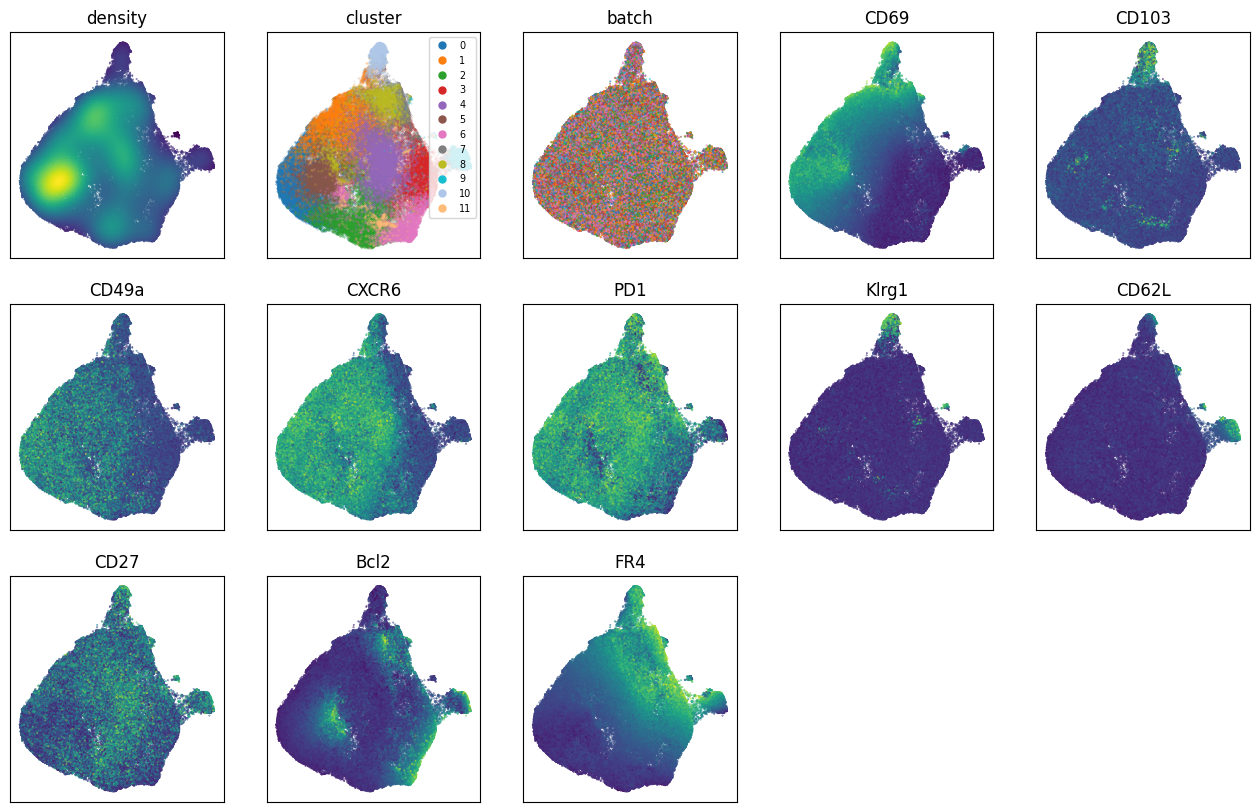

In [17]:
## compute the density of points

print("doing KDE")
ran_idxs = np.random.choice(num_samples, min(num_samples, 1000), replace=False)
col_dens = gaussian_kde(raw_latent_umap[ran_idxs, :].T)(raw_latent_umap.T)

## plot results
fig, axs = plt.subplots(3, 5, figsize=(16,10))

ax = axs.flatten()[0]
ax.scatter(raw_latent_umap[:,0], raw_latent_umap[:,1], s=0.1, c=col_dens)
ax.set_title("density")


## times are required for classification
raw_times = sample_day - T0
tensor_times = torch.Tensor(raw_times).cuda()

## for reproducibility, choose random seed (only important for saved model)
pyro.set_rng_seed(5675)

## plot clusters
tensor_clus = vae.classifier(
    tensor_data,
    xtime_index_tensor.cuda(),
    utime_tensor.cuda(),
    tensor_batch_onehot,
    method="sample"
)

raw_clus = tensor_clus.cpu().detach().numpy()
unique_clus = sorted(list(set(raw_clus)))

clus_sizes = utilities.count_unique_values(raw_clus)

## HACK: instead of sorting by size, we use a fixed relabeling (roughly sorted by size)

#clus_sorted_by_size = sorted(unique_clus, key=lambda x: clus_sizes[x], reverse=True)
#clus_relabel_dict = {c : i for i, c in enumerate(clus_sorted_by_size)}

## relabel clusters to have a fixed order (use for the pre-fitted model)

clus_relabel_dict = {10: 0, 5: 1, 6: 2, 4: 3, 1: 4, 7: 5, 8: 6, 2: 7, 3: 8, 0: 9, 11: 10, 9: 11}
clus_sorted_by_size = sorted(list(clus_relabel_dict.keys()), key=lambda x: clus_relabel_dict[x])


## plot cluster centroids (in UMAP space)

ax = axs.flatten()[1]
for i, uc in enumerate(clus_sorted_by_size):
    raw_latent_umap_clus = raw_latent_umap[raw_clus == uc, :]
    col = clus_color_dict[i]
    ax.scatter(
        raw_latent_umap_clus[:,0], 
        raw_latent_umap_clus[:,1],
        s=0.1,
        alpha=0.5,
        label=str(uc),
        color=col
    )
    ax.set_title("cluster")
    
## add legend for clusters
handles = [
    matplotlib.lines.Line2D(
        [], [], 
        color=clus_color_dict[c], 
        marker='o',
        label=str(c),
        linewidth=0,
        markersize=5
    )
    for c in range(vae.num_clus)
]
ax.legend(handles=handles, fontsize='x-small')

## show batches

batch_color_dict = dict(zip(unique_batch, itertools.cycle(mcolors.TABLEAU_COLORS)))
batch_colors = [batch_color_dict[b] for b in raw_batch]
perm = np.random.permutation(len(batch_colors))
batch_colors_perm = [batch_colors[i] for i in perm]

ax = axs.flatten()[2]
ax.scatter(raw_latent_umap[perm,0], raw_latent_umap[perm,1], s=0.1, c=batch_colors_perm)
ax.set_title("batch")

    
## plot marker expression

for i in range(feature_dim):
    ax = axs.flatten()[i+3]
    col_mark = raw_data[:,i]
    ax.scatter(raw_latent_umap[:,0], raw_latent_umap[:,1], s=0.1, c=col_mark)
    ax.set_title(sel_markers[i])
    
for i, ax in enumerate(axs.flatten()):
    ax.set_xticks([]); ax.set_yticks([])
    if i >= feature_dim + 3:
        ax.axis('off')

### MFI per cluster and per marker

Check out the avarage marker expression per cluster. We can use this to annotate cell types

relabeling clusters as follows: {10: 0, 5: 1, 6: 2, 4: 3, 1: 4, 7: 5, 8: 6, 2: 7, 3: 8, 0: 9, 11: 10, 9: 11}


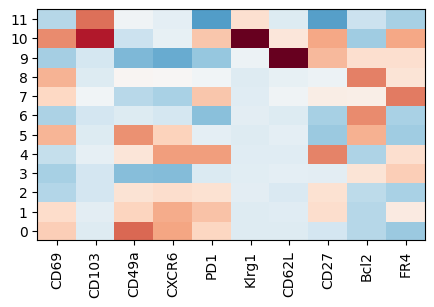

In [18]:
print("relabeling clusters as follows:", clus_relabel_dict)

MFI = np.zeros((vae.num_clus, feature_dim))

for i, clus in enumerate(clus_sorted_by_size):
    for j in range(feature_dim):
        expression_data = raw_data[raw_clus == clus, j]
        MFI[i,j] = np.mean(expression_data)
        
MFI = sts.zscore(MFI, axis=0) ## axis=0 means standardize over the the cell types!

fig, ax = plt.subplots(1, 1, figsize=(5,3))

plots.simple_heatmap(ax, MFI, sel_markers, range(vae.num_clus))

### Manual annotation of GMM clusters and sampling

doing KDE
sampling for cluster 0
sampling for cluster 1
sampling for cluster 2
sampling for cluster 3
sampling for cluster 4
sampling for cluster 5
sampling for cluster 6
sampling for cluster 7
sampling for cluster 8
sampling for cluster 9
sampling for cluster 10
sampling for cluster 11


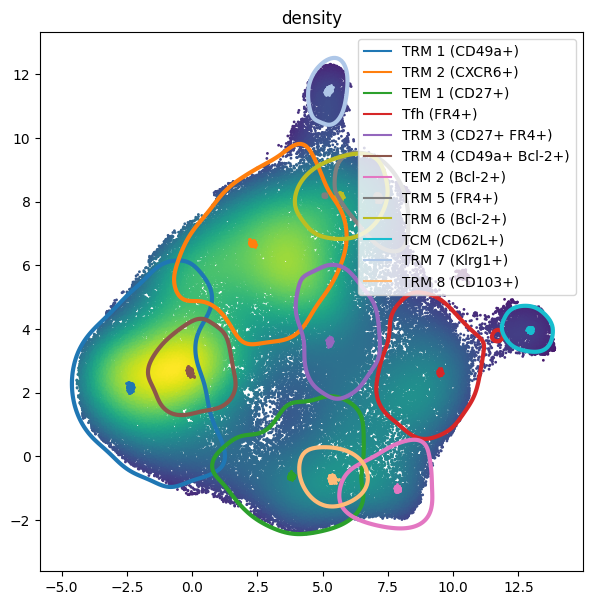

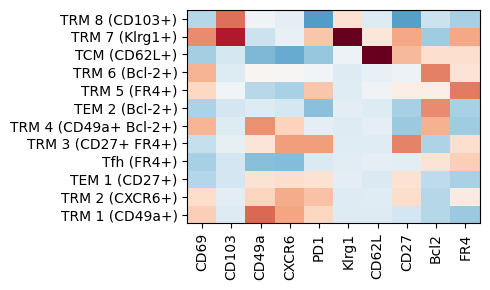

In [19]:
## hand-curated cell types
celltypedict = {
    0 : "TRM 1 (CD49a+)",
    1 : "TRM 2 (CXCR6+)",
    2 : "TEM 1 (CD27+)",
    3 : "Tfh (FR4+)",
    4 : "TRM 3 (CD27+ FR4+)",
    5 : "TRM 4 (CD49a+ Bcl-2+)",
    6 : "TEM 2 (Bcl-2+)",
    7 : "TRM 5 (FR4+)",
    8 : "TRM 6 (Bcl-2+)", 
    9 : "TCM (CD62L+)",
    10 : "TRM 7 (Klrg1+)",
    11 : "TRM 8 (CD103+)",    
}

## plot contours of clusters
fig, ax = plt.subplots(1, 1, figsize=(7,7))

print("doing KDE")
ran_idxs = np.random.choice(num_samples, min(num_samples, 1000), replace=False)
sample_density_umap = gaussian_kde(raw_latent_umap[ran_idxs, :].T)(raw_latent_umap.T)

ax.scatter(raw_latent_umap[:,0], raw_latent_umap[:,1], s=1, c=sample_density_umap)
ax.set_title("density")    

pred = Predictive(vae.mix, guide=vae.mix.guide, num_samples=1000)
sams = pred()
clus_locs_raw = sams["clus_locs"].cpu().numpy()

patches = []

umap_sampled_per_clus = {}

for i, clus in enumerate(clus_sorted_by_size):
    print(f"sampling for cluster {i}")
    time = torch.zeros((1,), device=vae.device)
    z_sam, x_sam = vae._posterior_sample_old(1000, time, clus=clus) # FIXME: batch
    t_sam = reducer.transform(z_sam.cpu().detach().numpy())
    patch = plots.plot_hpd_contour(
        ax, t_sam, color=clus_color_dict[i], 
        linewidth=3, label=celltypedict[i]
    )
    patches.append(patch)
    
    tloc_sam = reducer.transform(clus_locs_raw[:,clus,:])    
    ax.scatter(tloc_sam[:,0], tloc_sam[:,1], color=clus_color_dict[i], s=1)
    # save for figure
    umap_sampled_per_clus[clus] = {
        "samples" : t_sam,
        "loc" : tloc_sam,
    }


ax.legend(handles=patches)
    
## plot MFI matrix with annotations

fig, ax = plt.subplots(1, 1, figsize=(5,3))

plots.simple_heatmap(ax, MFI, sel_markers, [celltypedict[i] for i in range(vae.num_clus)])

fig.tight_layout()


## KNN to measure the effect of batch-effect corrections

In this analysis, we test the batch effect layer by giving all cells the same batch ID. We then use the encoder to calculate a latent representation. The idea is that if batch effects are severe, than cells from the same batch tend to be clustered in the sense that neighboring cells are more likely from the same batch than from other batches. We measure this similarity by entropy and find neignbors using the KNN algorithm. If batch correction works, the latent space embedding with a mock batch assignment (i.e. one single batch ID for all cells) should produce higher KL divergence scores than for cells in the batch-corrected embedding. KL divergence is calculated relative to batch sizes (i.e. relative number of cells per mouse).

<div class="alert alert-block alert-info"> <b>NOTE</b> 
    This can take some time... (about 5 minutes)
</div>

In [20]:
%%time

## select a 'reference' batch
batch_counts = collections.Counter(raw_batch)
largest_batch = max(batch_counts, key=lambda x: batch_counts[x])

expt_counts = collections.Counter(raw_expt)
largest_expt = max(expt_counts, key=lambda x: expt_counts[x])

mock_batch = [largest_batch for _ in raw_batch]
mock_expt = [largest_expt for _ in raw_expt]

print("largest batch:", largest_batch, batch_counts[largest_batch])
print("largest expt:", largest_expt, expt_counts[largest_expt])

## make a mock one-hot batch tensor in which everone is the reference

mock_batch_expt_onehot, _, _ = onehot_encoding(
    unique_batch, mock_batch, unique_expt, mock_expt, 0.1,
    batch_ref=largest_batch, expt_ref=largest_expt
)

## check out latent representations using vae.dimension_reduction

tensor_mock_batch_onehot = torch.Tensor(mock_batch_expt_onehot).cuda()
tensor_latent_mock_batch = vae.dimension_reduction(tensor_data, tensor_times, tensor_mock_batch_onehot)
raw_latent_mock_batch = tensor_latent_mock_batch.cpu().detach().numpy()

raw_latent_mock_batch_umap, _ = apply_umap(raw_latent_mock_batch)
    
## compute entropy in batch corrected and mock embeddings

hs, hs_rand = utilities.nn_analysis(raw_latent, raw_batch, unique_batch, relative=True)

hs_mock, hs_rand_mock = utilities.nn_analysis(raw_latent_mock_batch, raw_batch, unique_batch, relative=True)

largest batch: 16 9391
largest expt: 0 100000
doing UMAP...
background label distribution: [0.06621 0.08475 0.08859 0.05746 0.05414 0.08622 0.09391 0.03209 0.03339
 0.04895 0.02051 0.05334 0.01573 0.02728 0.0207  0.03102 0.01462 0.0137
 0.02054 0.00979 0.00879 0.00738 0.00994 0.01626 0.01249 0.00852 0.06368]
background label distribution: [0.06621 0.08475 0.08859 0.05746 0.05414 0.08622 0.09391 0.03209 0.03339
 0.04895 0.02051 0.05334 0.01573 0.02728 0.0207  0.03102 0.01462 0.0137
 0.02054 0.00979 0.00879 0.00738 0.00994 0.01626 0.01249 0.00852 0.06368]
CPU times: user 3h 1min 52s, sys: 4min 41s, total: 3h 6min 34s
Wall time: 4min


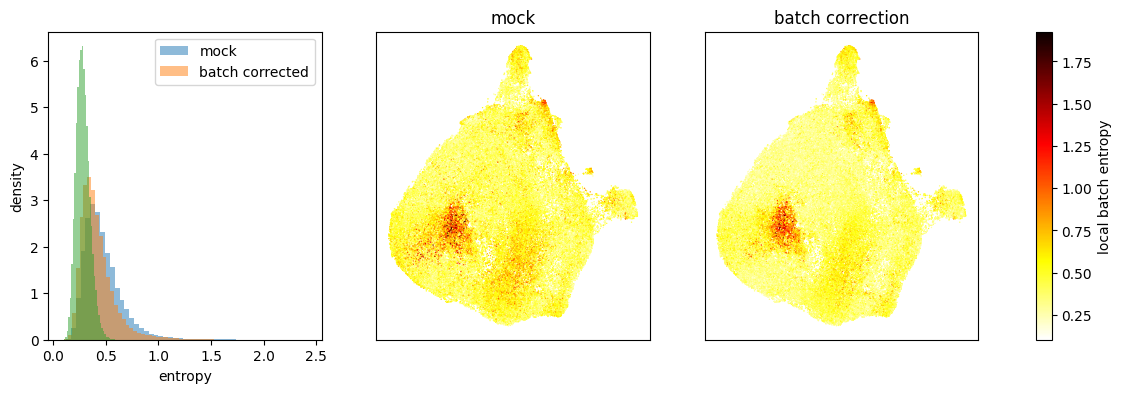

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))

## plot histograms
ax = axs[0]
ax.hist(hs_mock, 50, density=True, alpha=0.5, label="mock")
ax.hist(hs, 50, density=True, alpha=0.5, label="batch corrected")
ax.hist(hs_rand, 50, density=True, alpha=0.5)

ax.legend()

ax.set_xlabel("entropy")
ax.set_ylabel("density")

vmin, vmax = np.min(hs), np.max(hs)

## plot entropy in UMAP
ax = axs[1]
C = ax.scatter(
    raw_latent_umap[:,0], raw_latent_umap[:,1], s=1, 
    c=hs_mock, vmin=vmin, vmax=vmax, cmap='hot_r',
    rasterized=True, linewidths=0
)
ax.set_title("mock")

ax = axs[2]
ax.scatter(
    raw_latent_umap[:,0], raw_latent_umap[:,1], s=1, 
    c=hs, vmin=vmin, vmax=vmax, cmap='hot_r',
    rasterized=True, linewidths=0
)
ax.set_title("batch correction")

for ax in axs[1:]:
    ax.set_xticks([])
    ax.set_yticks([])

cx = fig.colorbar(C, ax=axs)
cx.set_label("local batch entropy")

### Export batch correction results for an SI figure

We need the relative entropies, and include UMAP coordinates

In [22]:
## Export batch correction results for an SI figure

data_figure_batch_correction = {
    "hs" : hs,
    "hs_mock" : hs_mock,
    "hs_rand" : hs_rand,
    "latent_umap" : raw_latent_umap,
}

with open("../results/data_figure_batch_correction_CD4.pkl", 'wb') as f:
    pickle.dump(data_figure_batch_correction, f)

## Plot fitted timeseries

Notice that the timeseries are in part generated using the fitted model.
Hence, these are not "model fits" in the true sense of comparing the 
fitted model trajectories with the data.

Text(0.5, 0, 'DPI')

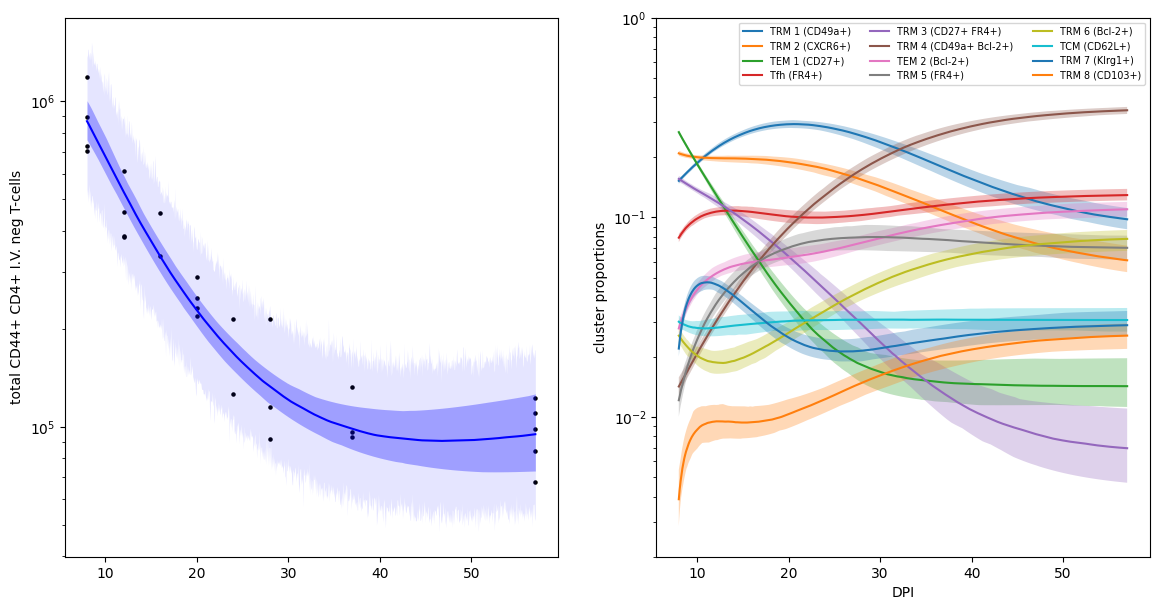

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14,7))

axs[0].set_yscale('log')
axs[0].scatter(
    np.array([x[0]+T0 for x in raw_count_data_combined]),
    np.array([x[1] for x in raw_count_data_combined]) * scaling,
    s=5, color='k'
)


ts_raw = np.linspace(
    np.min(unique_sample_day), 
    np.max(unique_sample_day), 1000,
    dtype=np.float32
) - T0
ts_tensor = torch.tensor(ts_raw).cuda()

weights_tensor, yhats_tensor, ysims_tensor = vae.sample_trajectories(ts_tensor, n=200)

weights_raw = weights_tensor.cpu().detach().numpy()
weights_low, weights_med, weights_hi = np.percentile(weights_raw, q=[2.5, 50, 97.5], axis=0)

yhats_raw = yhats_tensor.cpu().detach().numpy()
yhats_low, yhats_med, yhats_hi = np.percentile(yhats_raw, q=[2.5, 50, 97.5], axis=0)

ysims_raw = ysims_tensor.cpu().detach().numpy()
ysims_low, ysims_med, ysims_hi = np.percentile(ysims_raw, q=[2.5, 50, 97.5], axis=0)

axs[0].plot(ts_raw+T0, yhats_med * scaling, color='b')
axs[0].fill_between(ts_raw+T0, yhats_low * scaling, yhats_hi * scaling, alpha=0.3, color='b', linewidth=0)
axs[0].fill_between(ts_raw+T0, ysims_low * scaling, ysims_hi * scaling, alpha=0.1, color='b', linewidth=0)


for i, clus in enumerate(clus_sorted_by_size):
    label = celltypedict[i]
    #label = None
    axs[1].plot(ts_raw+T0, weights_med[:,clus], label=label)
    axs[1].fill_between(ts_raw+T0, weights_low[:,clus], weights_hi[:,clus], alpha=0.3, linewidth=0)
    
## titles etc
axs[0].set_ylabel("total CD44+ CD4+ I.V. neg T-cells")
axs[1].set_ylabel("cluster proportions")

axs[1].legend(ncol=3, fontsize='x-small')

axs[1].set_yscale('log'); axs[1].set_ylim(2e-3, 1)

axs[1].set_xlabel("DPI")

### Compute and show the distances between the clusters

Use positions in latent space.
The locations in the latent space are quite narrowly defined.
Therefore, we use the mean over posterior samples to generate a single distance matrix.

[Text(0, 0.5, 'TRM 1 (CD49a+)'),
 Text(0, 1.5, 'TRM 2 (CXCR6+)'),
 Text(0, 2.5, 'TEM 1 (CD27+)'),
 Text(0, 3.5, 'Tfh (FR4+)'),
 Text(0, 4.5, 'TRM 3 (CD27+ FR4+)'),
 Text(0, 5.5, 'TRM 4 (CD49a+ Bcl-2+)'),
 Text(0, 6.5, 'TEM 2 (Bcl-2+)'),
 Text(0, 7.5, 'TRM 5 (FR4+)'),
 Text(0, 8.5, 'TRM 6 (Bcl-2+)'),
 Text(0, 9.5, 'TCM (CD62L+)'),
 Text(0, 10.5, 'TRM 7 (Klrg1+)'),
 Text(0, 11.5, 'TRM 8 (CD103+)')]

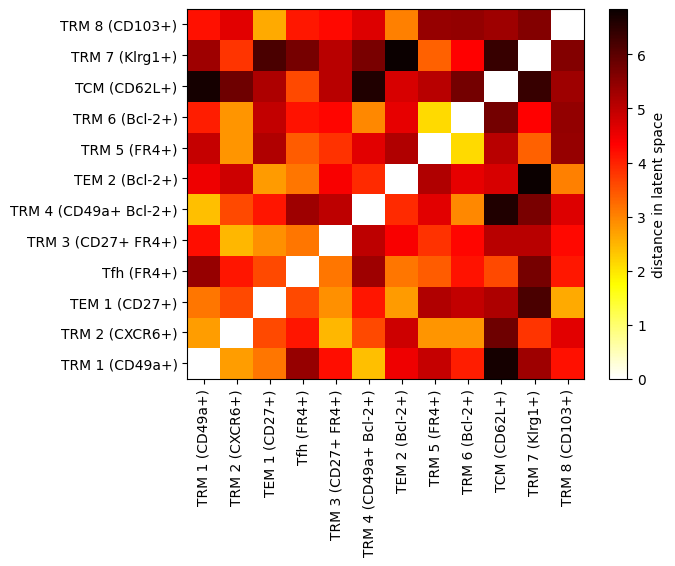

In [24]:
def gmm_model_wrap():
    locs, chols = vae.mix()
    pyro.deterministic("locs", locs)
    pyro.deterministic("chols", chols)

pred = Predictive(gmm_model_wrap, guide=vae.mix.guide, num_samples=200)
sams = pred()

clus_locs = sams["locs"]

Dmat = cluster_distance_matrix(clus_locs)

mDmat = Dmat.mean(axis=0)

mDmat_raw = mDmat.detach().cpu().numpy()

fig, ax = plt.subplots(1, 1)

C = ax.pcolor(mDmat_raw[clus_sorted_by_size,:][:,clus_sorted_by_size], cmap='hot_r')
cax = fig.colorbar(C)
cax.set_label("distance in latent space")

ticks = np.linspace(0, num_clus-1, num_clus)+0.5
ax.set(xticks=ticks, yticks=ticks)
labs = [celltypedict[i] for i in range(num_clus)]
ax.set_xticklabels(labs, rotation=90)
ax.set_yticklabels(labs)

### Cleanup some space

At this point, I sometimes run out of VRAM. 

In [25]:
import torch
import gc

# Clear Python garbage
gc.collect()

# Optionally, clear CUDA cache if using PyTorch with CUDA
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### Show the differentiation matrix $Q$

<div class="alert alert-block alert-info"> <b>NOTE</b> 
    Skip this step for models without differentiation.
</div>

Also plot the hyperparameters for the $Q$ matrix.
In the "distance-guided differentiation" model, we let the distance between clusters in latent space have an effect on the prior for $Q_{ij}$.
This uses a `loc_Q` location parameter and a `weight_shape_Q` weight parameter of the distance matrix on the prior of $Q$.
To avoid correlations between `loc_Q` and `weight_shape_Q`, the distance matrix is centered around zero. 

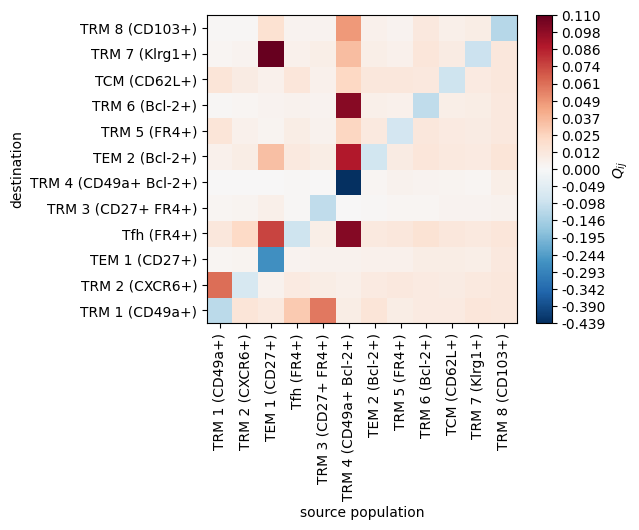

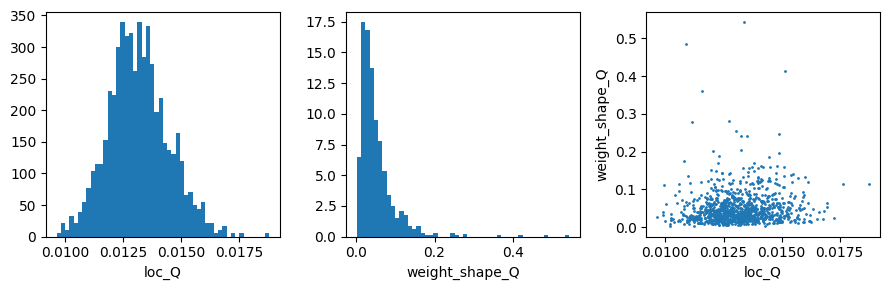

In [26]:
pred = Predictive(vae.dyn_model, guide=vae.dyn_model.guide, num_samples=1000, parallel=True)
samples = pred(ts_tensor, shape_Q = mDmat)
   
Qsams = samples["Qoffdiag"].detach().cpu()
fig, ax = plt.subplots(1, 1, figsize=(5,4))
plots.plot_diff_matrix_vae(ax, Qsams, unique_clus, clus_sorted_by_size, celltypedict)
    
loc_Q_hat = samples["loc_Q"].cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(9,3))
ax = axs[0]
ax.hist(loc_Q_hat, 50, density=True)
ax.set_xlabel("loc_Q")

weight_shape_Q_hat = samples["weight_shape_Q"].cpu().numpy()

ax = axs[1]
ax.hist(weight_shape_Q_hat, 50, density=True)
ax.set_xlabel("weight_shape_Q")

ax = axs[2]
ax.scatter(loc_Q_hat, weight_shape_Q_hat, s=1)
ax.set(ylabel="weight_shape_Q", xlabel="loc_Q")

fig.tight_layout()

### plot samples from Q as a function of samples from the distance matrix

Show the effect of the "distance-guided differentiation model". If distance is used
to guide differentiation, then the $Q_{ij}$ values should be smaller for clusters $i$ and $j$ that 
are far away from each other.

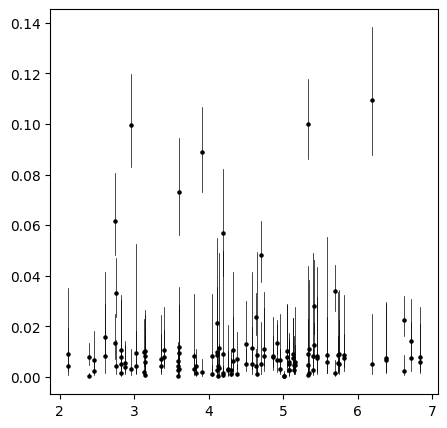

In [27]:
pred = Predictive(vae.dyn_model, guide=vae.dyn_model.guide, num_samples=1000, parallel=True)

samples = pred(ts_tensor, shape_Q = mDmat)

Qoffdiag_raw = samples["Qoffdiag"].detach().cpu().numpy()

mDoffdiag_raw = scdynsys.vae.dyn.remove_diagonal(mDmat).detach().cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(5,5))

mQ = np.median(Qoffdiag_raw, axis=0)
lQ, uQ = np.percentile(Qoffdiag_raw, axis=0, q=[2.5, 97.5])

ax.scatter(mDoffdiag_raw.flatten(), mQ.flatten(), s=5, color='k')

for i, x, in enumerate(mDoffdiag_raw.flatten()):
    l, u = lQ.flat[i], uQ.flat[i]
    ax.plot([x,x], [l, u], color='k', linewidth=0.5)


### save distance and Q matrix data for SI figure

In [28]:
## save the data for SI figure

data_figure_Qprior = {
    "mQ" : mQ,
    "lQ" : lQ,
    "uQ" : uQ,
    "D" : mDoffdiag_raw,
    "loc_Q" : loc_Q_hat,
    "weight_shape_Q" : weight_shape_Q_hat,
}

with open("../results/data_figure_Qprior_CD4.pkl", 'wb') as f:
    pickle.dump(data_figure_Qprior, f)

## Posterior predictive intervals for cluster frequencies

Above, we have already shown the inferred trajectories of the relative cluster sizes, but we would still like to compare them to "data".
One issue is that this "data" is also in part generated by the model. as we used the trained model do do the classification of the 
flow data.
Below, we also compute posterior predictive distributions for all mice.

In [29]:
## create posterior predictive intervals for cluster frequencies

batch_counts = utilities.count_unique_values(raw_batch)
freq_ppi = {}
for i, batch in enumerate(unique_batch):
    t = batch_day_dict[batch] - T0
    ## for simplicity, use mock batch effects
    s_raw = np.zeros((1,vae.num_batch))
    n = batch_counts[batch]
    freq_ppi[batch] = compute_ppd_freqs(vae, t, n, s_raw.flatten(), 200)

Next, we plot trajectories for each cluster in a separate panel, 
and add inferred data points for each mouse, in addition to 95% CrI of the PPD.

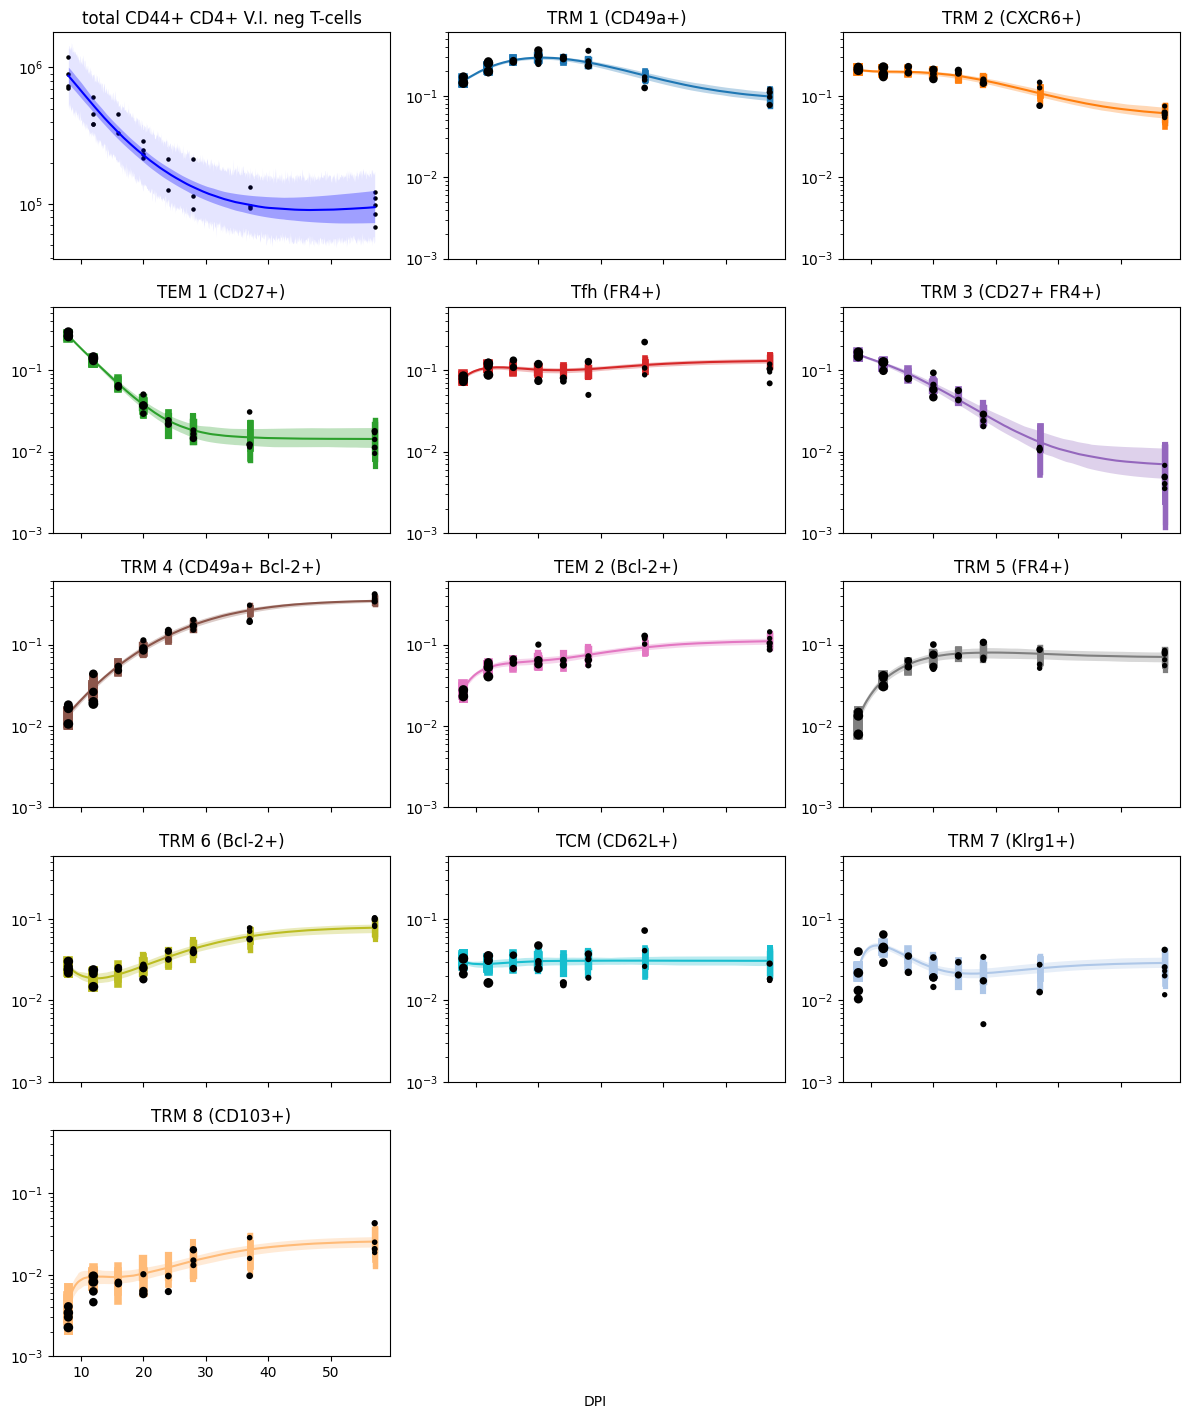

In [30]:
## infer data points to compare with the fit

nax = vae.num_clus + 1
cols = 3
rows = nax // cols + (0 if nax % cols == 0 else 1)
fig, axss = plt.subplots(rows, cols, figsize=(12, 14), sharex=True)
axs = axss.flatten()

axs[0].set_yscale('log')
axs[0].scatter(
    np.array([x[0]+T0 for x in raw_count_data_combined]),
    np.array([x[1] for x in raw_count_data_combined]) * scaling,
    s=5, color='k'
)

axs[0].plot(ts_raw+T0, yhats_med * scaling, color='b')
axs[0].fill_between(ts_raw+T0, yhats_low * scaling, yhats_hi * scaling, alpha=0.3, color='b', linewidth=0)
axs[0].fill_between(ts_raw+T0, ysims_low * scaling, ysims_hi * scaling, alpha=0.1, color='b', linewidth=0)
axs[0].set_title("total CD44+ CD4+ V.I. neg T-cells")


## generate data points

clus_freq_array = np.zeros((num_batch, vae.num_clus))
batch_sample_size = np.zeros(num_batch)

for i, ub in enumerate(unique_batch):
    clus_ub = raw_clus[raw_batch == ub]
    clus_ub_counts = np.array([np.sum(clus_ub == c) for c in range(vae.num_clus)])
    clus_ub_freqs = clus_ub_counts / np.sum(clus_ub_counts)
    batch_sample_size[i] = np.sum(clus_ub_counts)
    clus_freq_array[i,:] = clus_ub_freqs    
    
dot_sizes = np.sqrt(batch_sample_size / max(batch_sample_size)) * 50
        
## plot frequencies
for i, clus in enumerate(clus_sorted_by_size):
    ax = axs[i+1]
    label = celltypedict[i]
    
    ## predictions
    ax.plot(ts_raw+T0, weights_med[:,clus], color=clus_color_dict[i])
    ax.fill_between(
        ts_raw+T0, weights_low[:,clus], weights_hi[:,clus], 
        alpha=0.3, linewidth=0, color=clus_color_dict[i]
    )
    ax.set_title(label)
    
    ## data points
    obs_times = [batch_day_dict[b] for b in unique_batch]
    ax.scatter(obs_times, clus_freq_array[:,clus], s=dot_sizes, linewidths=0, c='k', zorder=2)
    
    ## posterior predictive intervals
    fs = [freq_ppi[b][:,clus] for b in unique_batch]
    for t, f, ds in zip(obs_times, fs, dot_sizes):
        ax.plot([t,t], f, color=clus_color_dict[i], linewidth=np.sqrt(ds), zorder=1)
    
    ax.set_yscale('log')

freq_axs = axs[1:vae.num_clus+1]
for ax in freq_axs:
    ax.sharey(freq_axs[0])
#freq_axs[0].autoscale(axis='y')
freq_axs[0].set_ylim(1e-3, 6e-1)
    
## remove un-used axes
for i, ax in enumerate(axs):
    if i >= nax:
        ax.axis('off')
        
fig.text(0.5, 0, "DPI", ha='center', va='top')
        
fig.tight_layout()

### Show cluster size evolution in UMAP space

This is an laternative way to show how the relative cluster sizes change with time.
Below, we will explore UMAP "fits" in more detail and make use of the generative aspect of the model.

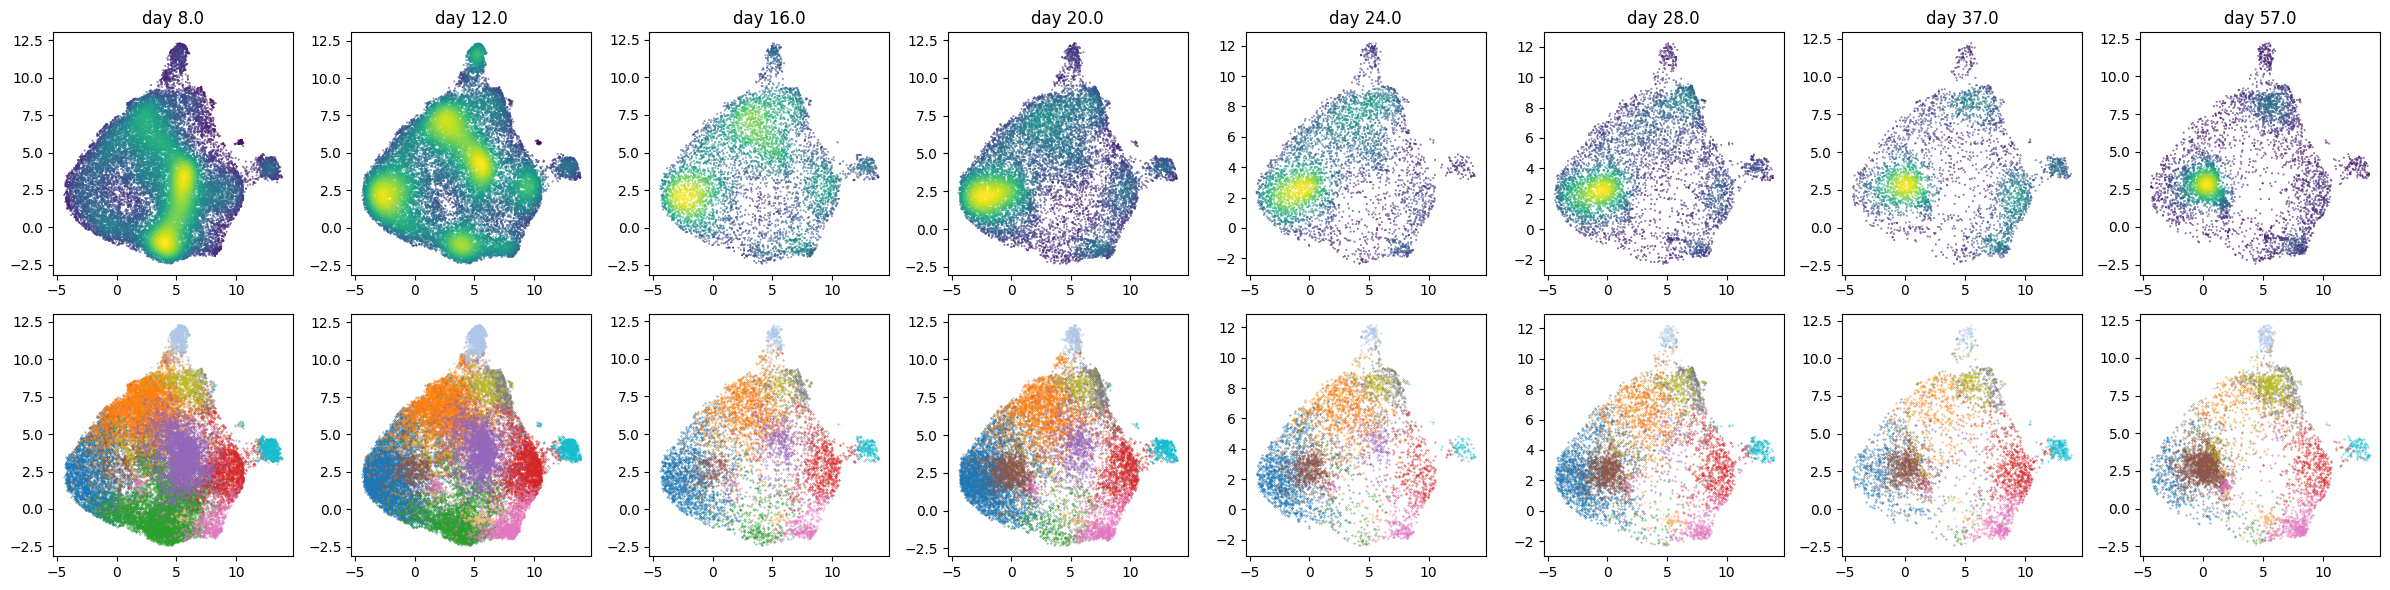

In [31]:
fig, axs = plt.subplots(2, len(unique_sample_day), figsize=(3*len(unique_sample_day), 6))

for i, ud in enumerate(unique_sample_day):  
    umap_day = raw_latent_umap[sample_day == ud, :]
    n = umap_day.shape[0]
    ran_idxs = np.random.choice(n, min(n,10000), replace=False)
    col_dens = gaussian_kde(umap_day[ran_idxs, :].T)(umap_day.T)    
    axs[0,i].scatter(umap_day[:,0], umap_day[:,1], s=0.1, label=str(ud), c=col_dens)
    axs[0,i].set_title(f"day {ud}")
    
    for j, clus in enumerate(clus_sorted_by_size):
        raw_latent_umap_clus = raw_latent_umap[np.logical_and(raw_clus == clus, sample_day == ud), :]
        axs[1,i].scatter(
            raw_latent_umap_clus[:,0], 
            raw_latent_umap_clus[:,1], 
            s=0.1, 
            color=clus_color_dict[j]
        )

fig.tight_layout()        

### Check out posterior distribution of rho, eta, logX0

in addition to other parameters like $u$ and $\sigma_M$


In [32]:
pred = Predictive(
    vae.dyn_model, 
    guide=vae.dyn_model.guide,
    num_samples=1000,
    parallel=True
)

t_eval = torch.linspace(0.0, 70.0, 100, device=vae.device)

sams = pred(t_eval)


rho_sam = sams["rho"].detach().cpu().numpy()
loc_rho_sam = sams["loc_rho"].detach().cpu().numpy()

if "eta" in sams:
    eta_sam = sams["eta"].detach().cpu().numpy()
    loc_eta_sam = sams["loc_eta"].detach().cpu().numpy()
else:
    eta_sam = None
    loc_eta_sam = None

logX0_sam = sams["logX0"].detach().cpu().numpy()

if "u" in sams:
    u_sam = sams["u"].detach().cpu().numpy()
else:
    u_sam = None

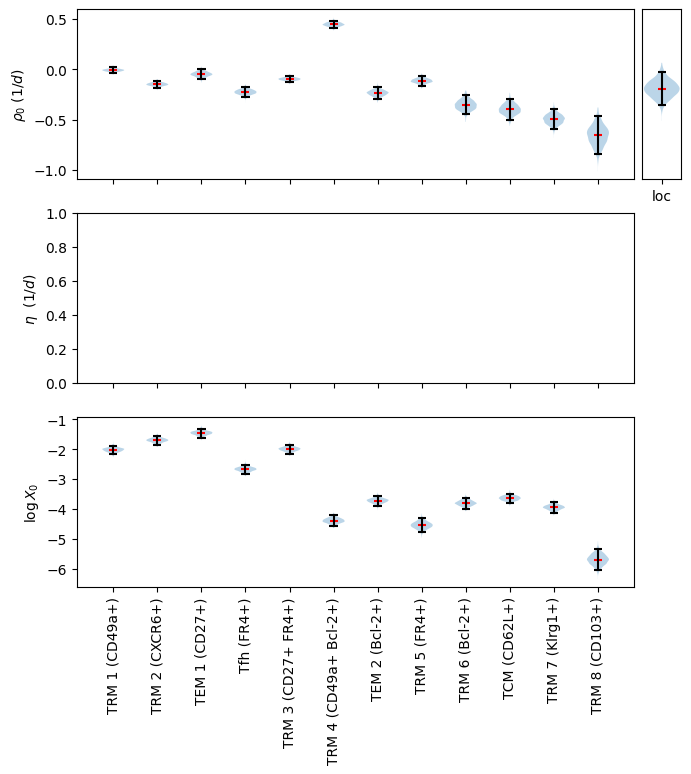

In [33]:
pos = [clus_relabel_dict[clus] for clus in unique_clus]

fig, _, _ = plots.plot_mpd_array(
    [rho_sam, eta_sam, logX0_sam], 
    [loc_rho_sam, loc_eta_sam, None], 
    pos, 
    [celltypedict[i] for i in pos], 
    ["$\\rho_0$ ($1/d$)", "$\\eta$  ($1/d$)", "$\\log X_0$"]
)

y_scale variational estimates tensor(-1.3788) tensor(0.1350)


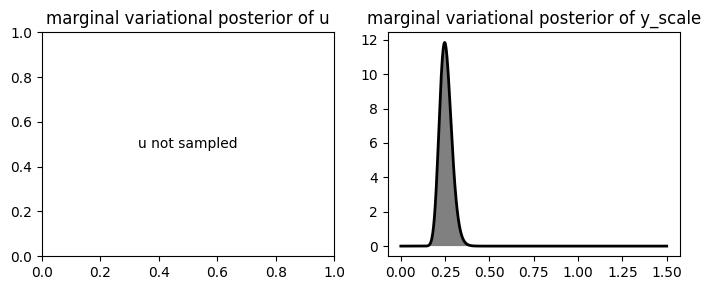

In [34]:
## check out posterior distribution of u

fig, axs = plt.subplots(1, 2, figsize=(7,3))

ax = axs[0]
if u_sam is not None:
    ax.hist(u_sam, 50, density=True)
    print("95% CrI u", np.percentile(u_sam, q=[2.5, 97.5]))
    print("95% CrI t_1/2 u", np.percentile(np.log(2) / u_sam, q=[2.5, 97.5]))
else:
    ax.text(0.5, 0.5, "u not sampled", va='center', ha='center')

ax.set_title("marginal variational posterior of u")




## check out posterior distribution of y_scale

store = pyro.get_param_store()

y_scale_vari_loc = store["y_scale_vari_loc"].cpu().detach()
y_scale_vari_scale = store["y_scale_vari_scale"].cpu().detach()

print("y_scale variational estimates", y_scale_vari_loc, y_scale_vari_scale)

xs = torch.linspace(1e-5, 1.5, 1000)
d = torch.distributions.LogNormal(y_scale_vari_loc, y_scale_vari_scale)
ys = d.log_prob(xs)

ax = axs[1]

ax.fill_between(xs.numpy(), ys.exp().numpy(), facecolor='gray')
ax.plot(xs.numpy(), ys.exp().numpy(), linewidth=2, color='k')

ax.set_title("marginal variational posterior of y_scale")

fig.tight_layout()

### Save data for creating a IA model fit figure

This figure is quite complex and requires a lot of information...

In [35]:
data_figure_IA_fit = {
    "raw_latent_umap" : raw_latent_umap,
    "sel_markers" : sel_markers,
    "raw_data" : raw_data,
    "MFI" : MFI,
    "clus_relabel_dict" : clus_relabel_dict,
    "raw_clus" : raw_clus,
    "umap_sampled_per_clus" : umap_sampled_per_clus,
    "sample_density_umap" : sample_density_umap,
    "ts_raw" : ts_raw,
    "yhats_raw" : yhats_raw,
    "weights_raw" : weights_raw,
    "unique_batch" : unique_batch,
    "batch_day_dict": batch_day_dict,
    "clus_freq_array" : clus_freq_array,
    "T0" : T0,
    "raw_count_data_combined" : raw_count_data_combined,
    "freq_ppi" : freq_ppi,
    "ysims_raw" : ysims_raw,
    "count_scaling" : scaling,
    "rho_sam" : rho_sam,
    "loc_rho_sam" : loc_rho_sam,
    "logX0_sam" : logX0_sam,
    "eta_sam" : eta_sam,
    "loc_eta_sam" : loc_eta_sam,
    "Qsams" : Qsams,
    "idxs_test_train" : idxs_test_train,
}

with open("../results/data_IA_fitting_CD4.pkl", 'wb') as f:
    pickle.dump(data_figure_IA_fit, f)

# Do the analyses for the validation figure

Next, we do some analyses to validate the method: 

* UMAP-based timeseries
* Compare marginal distributions of markers with simulations
* VAE reconstruction

### Generate a movie or series of frames

'interpolate' between observed time points. We take a non-linear (piece-wise linear) time scale.
The first 20 days are the most "dynamic". So we take more interpolation points here.

At different sampling times, we have a different number of cells.
To make sure that simulated frames are similar to data frames,
we make sure that the simulated sample size is interpolated between the data flow cytometry events.

sampling 100000 points
number of samples per frame: [30323 29939 29556 29173 21631 14089  6548  8982 11417 13853 10834  7816
  4798  5176  5555  5934  4923  3912  4685  5459] 
sum: 254603


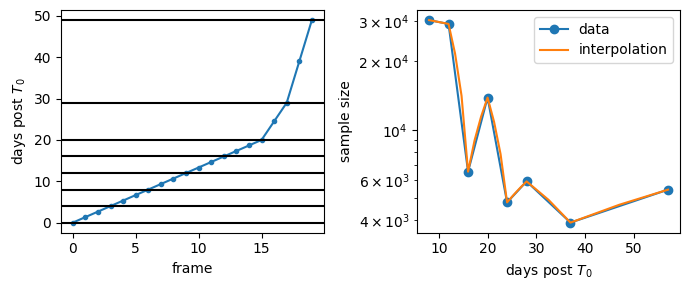

In [36]:
from scipy.interpolate import interp1d

xtimes_raw = np.concatenate([
    np.linspace(0, 20, 16)[:-1], 
    np.linspace(20, 29, 3)[:-1],
    np.linspace(29, 49, 3),
]) 
xtimes_tensor = torch.tensor(xtimes_raw, device=vae.device, dtype=torch.float32)
num_sams = 5000

print("sampling", num_sams * len(xtimes_raw), "points")

fig, axs = plt.subplots(1, 2, figsize=(7,3))

ax = axs[0]
ax.plot(xtimes_raw, marker='o', markersize=3)
for t in utime_raw:
    ax.axhline(t, color='k')

ax.set(xlabel="frame", ylabel="days post $T_0$")


## get the number of samples for each day to match sample size in simulations and data

num_sams_per_day_data = np.zeros(len(unique_sample_day))
for n, ud in enumerate(unique_sample_day):
    num_sams_per_day_data[n] = len([d for d in sample_day if d == ud])
    
ax = axs[1]
ax.plot(unique_sample_day, num_sams_per_day_data, marker='o', label="data")
ax.set_yscale('log')
ax.set(xlabel="days post $T_0$", ylabel="sample size")

## manually fit a curve to determine sample size for simulations at intermediate time points

interp_fun = interp1d(unique_sample_day, num_sams_per_day_data)    

sam_sizes_sim = np.array(interp_fun(xtimes_raw+T0), dtype='int')
ax.plot(xtimes_raw + unique_sample_day[0], sam_sizes_sim, label="interpolation")
ax.legend()

fig.tight_layout()

print("number of samples per frame:", sam_sizes_sim, "\nsum:", sum(sam_sizes_sim))

### Now generate pseudo data at intermediate time points

After simulation, we apply the trained UMAP projection to the simulated data points.

<div class="alert alert-block alert-warning"> <b>WARNING</b> 
    This can take some time...
</div>


In [37]:
%%time

zz_raws = []

for i, n in enumerate(sam_sizes_sim):
    print(f"time point: {i}, number of samples: {n}")
    time = xtimes_tensor[i:i+1]
    zz, xx, clus_vec = vae._posterior_sample_old(n, time) ## FIXME: experimental batch
    zz_raw = zz.squeeze().cpu().detach().numpy()

    del zz
    del xx
    del clus_vec

    torch.cuda.empty_cache()
    
    zz_raws.append(zz_raw)
    

# next, use the UMAP trained on the latent space data to map the simulated points to UMAP space.

flat_samples = np.concatenate(zz_raws)
flat_umap_samples = reducer.transform(flat_samples)

time point: 0, number of samples: 30323
time point: 1, number of samples: 29939
time point: 2, number of samples: 29556
time point: 3, number of samples: 29173
time point: 4, number of samples: 21631
time point: 5, number of samples: 14089
time point: 6, number of samples: 6548
time point: 7, number of samples: 8982
time point: 8, number of samples: 11417
time point: 9, number of samples: 13853
time point: 10, number of samples: 10834
time point: 11, number of samples: 7816
time point: 12, number of samples: 4798
time point: 13, number of samples: 5176
time point: 14, number of samples: 5555
time point: 15, number of samples: 5934
time point: 16, number of samples: 4923
time point: 17, number of samples: 3912
time point: 18, number of samples: 4685
time point: 19, number of samples: 5459
CPU times: user 16min 39s, sys: 1.67 s, total: 16min 40s
Wall time: 8min 28s


### Next, make a series of frames using UMAPed simulated data

Doing KDE for each frame can take some time, so we restrict the number of cells used for KDE to 1000

doing KDE for frame 0
doing KDE for frame 1
doing KDE for frame 2
doing KDE for frame 3
doing KDE for frame 4
doing KDE for frame 5
doing KDE for frame 6
doing KDE for frame 7
doing KDE for frame 8
doing KDE for frame 9
doing KDE for frame 10
doing KDE for frame 11
doing KDE for frame 12
doing KDE for frame 13
doing KDE for frame 14
doing KDE for frame 15
doing KDE for frame 16
doing KDE for frame 17
doing KDE for frame 18
doing KDE for frame 19


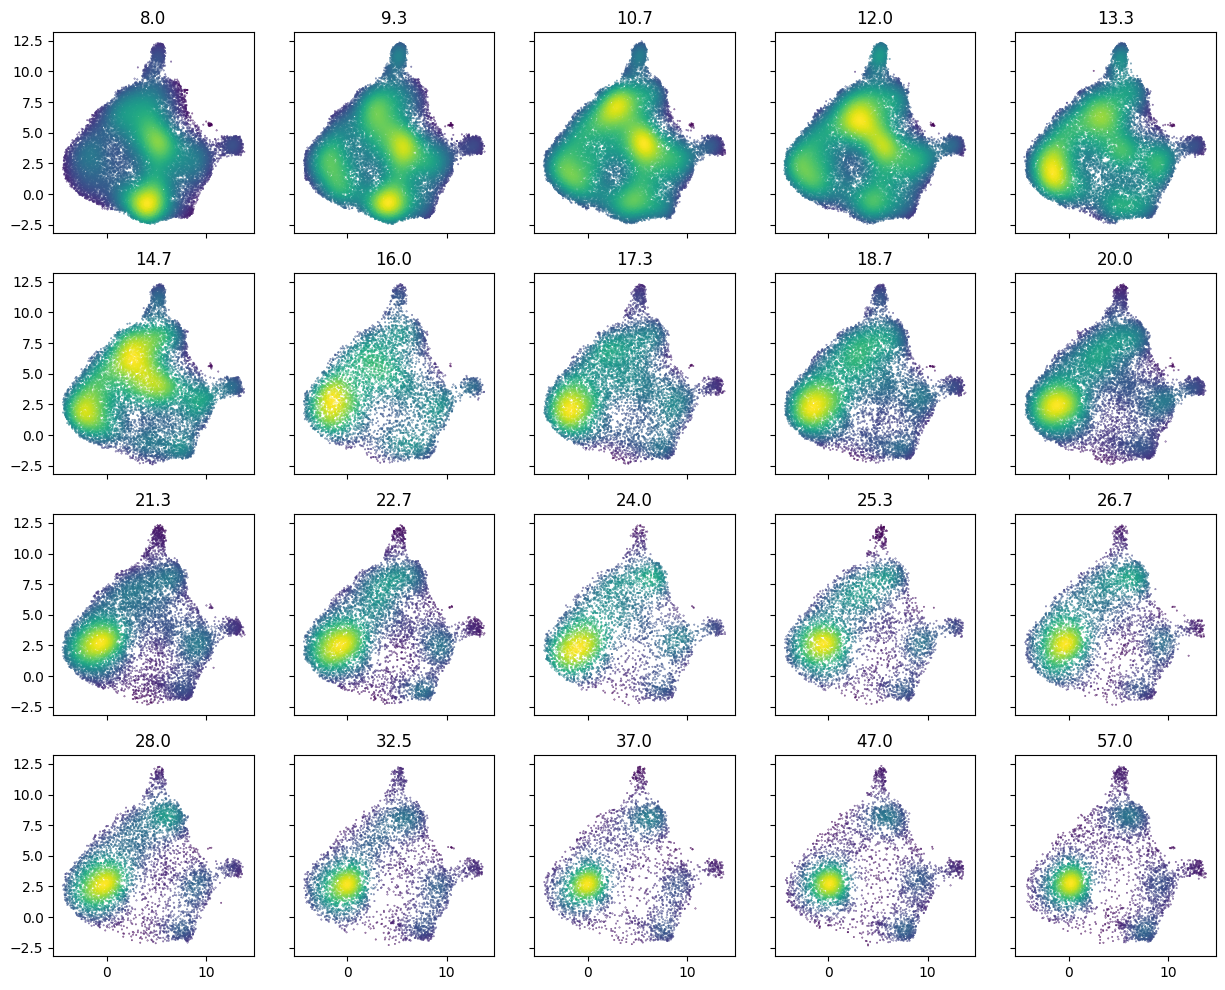

In [38]:
## unpack umap_samples (per time point)
umap_samples_sim = [
    flat_umap_samples[sum(sam_sizes_sim[:i]):sum(sam_sizes_sim[:i+1])] 
    for i in range(len(sam_sizes_sim))
]

num_cols = 4
num_rows = len(xtimes_raw) // num_cols + (0 if len(xtimes_raw) % num_cols == 0 else 1)

## plot results
fig, axs = plt.subplots(num_cols, num_rows, figsize=(3*num_rows,3*num_cols), sharex=True, sharey=True)

# save density for later

densities_per_frame_sim = []

for n, t in enumerate(xtimes_raw):
    ax = axs.flatten()[n]
    print("doing KDE for frame", n)
    sams = umap_samples_sim[n]
    k = sams.shape[0]
    ran_idxs = np.random.choice(k, min(k, 1000), replace=False)
    col_dens = gaussian_kde(sams[ran_idxs, :].T)(sams.T)
    densities_per_frame_sim.append(col_dens)
    ax.scatter(sams[:,0], sams[:,1], s=0.1, c=col_dens)
    ax.set_title(f"{t+T0:0.1f}")

### We want to interleave data and simulations: make frames for the data as well

In [39]:
# prepare data frames

densities_per_frame_data = []
umap_samples_data = []

for n, t in enumerate(unique_sample_day):
    umap_day = raw_latent_umap[sample_day == t, :]
    ran_idxs = np.random.choice(umap_day.shape[0], min(umap_day.shape[0], 5000), replace=False)
    col_dens = gaussian_kde(umap_day[ran_idxs, :].T)(umap_day.T)
    densities_per_frame_data.append(col_dens)
    umap_samples_data.append(umap_day)
    

### Combine data frames and simulated frames

* Show a gray box to indicate data frames
* add a panel with the location of the clusters (GMM components)

sampling cells per cluster to get HPD regions...
rendering frames for data ans simulations...


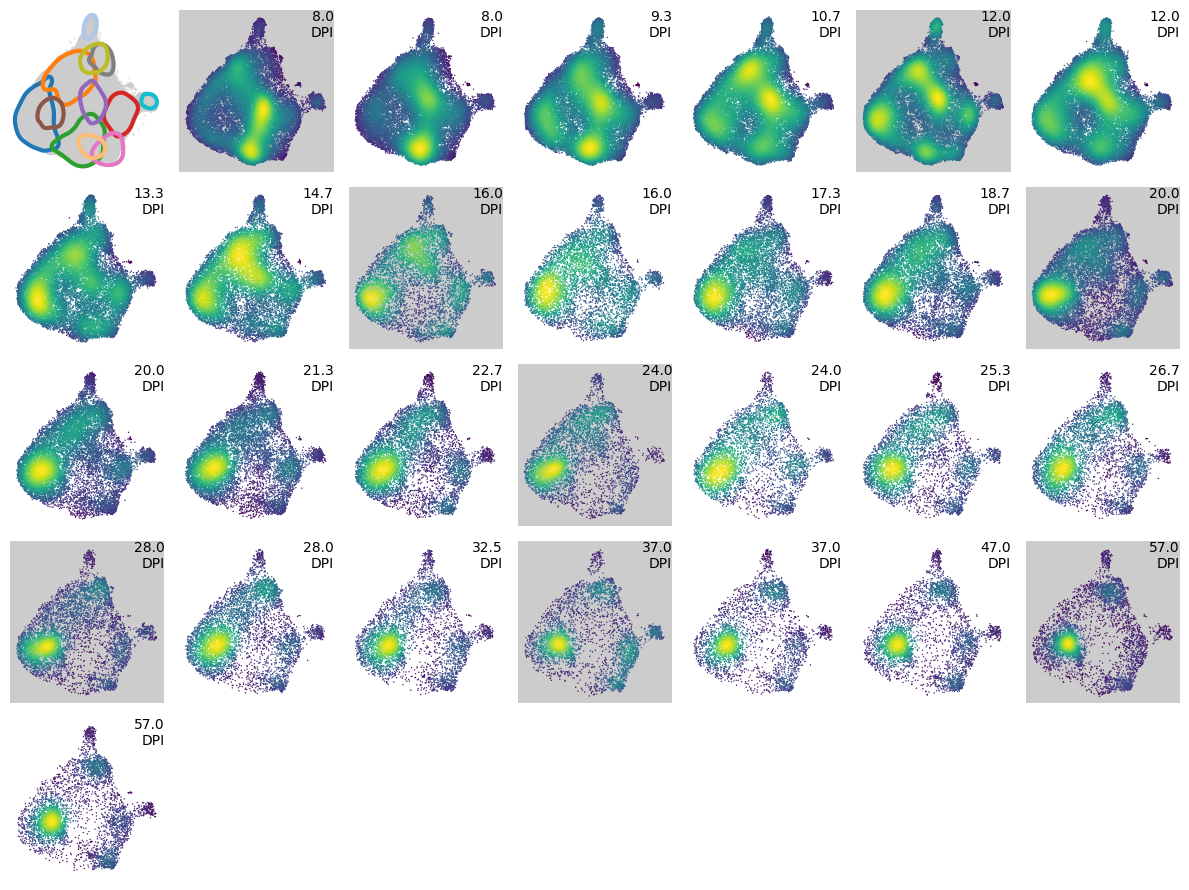

In [40]:
## interleave data and simulation

idxs_data = [(t, i, 'data') for i, t in enumerate(unique_sample_day)]
## make sure we use time in DPI for simulations
idxs_sim = [(t+T0, i, 'sim') for i, t in enumerate(xtimes_raw)]

idxs_mix = (idxs_data + idxs_sim)
idxs_mix.sort()

num_cols = 7
num_rows = 5

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12,9))

## indicate clusters in the first panel

ax = axs.flatten()[0]

ax.scatter(
    flat_umap_samples[:,0], flat_umap_samples[:,1], 
    s=0.1, color='0.8', rasterized=True
)

## compute HPD regions of each cluster and draw contour
print("sampling cells per cluster to get HPD regions...")
patches = []
transformed_samples_per_clus = []
for i, clus in enumerate(clus_sorted_by_size):
    time = torch.zeros((1,), device=vae.device)
    z_sam, x_sam = vae._posterior_sample_old(300, time, clus=clus) ## FIXME: experimental batch
    t_sam = reducer.transform(z_sam.cpu().detach().numpy())
    patch = plots.plot_hpd_contour(
        ax, t_sam, color=clus_color_dict[i], 
        linewidth=3, label=celltypedict[i]
    )
    patches.append(patch)
    transformed_samples_per_clus.append(t_sam)


## get good xlims and ylims by scattering all data

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.axis('off')

print("rendering frames for data ans simulations...")
for n, (t, i, s) in enumerate(idxs_mix):
    ax = axs.flatten()[n+1]
    if s == "sim":
        sams = umap_samples_sim[i]
        k = sams.shape[0]
        col_dens = densities_per_frame_sim[i]
        ax.scatter(sams[:,0], sams[:,1], s=1, c=col_dens, rasterized=True, linewidths=0)
    elif s == 'data':
        umap_day = umap_samples_data[i]
        col_dens = densities_per_frame_data[i]
        
        ax.scatter(umap_day[:,0], umap_day[:,1], s=1, c=col_dens, zorder=2, rasterized=True, linewidths=0)
        ax.axvspan(*xlim, color='0.8', linewidth=0, zorder=1)
    else:
        raise Exception("invalid frame type")
    ax.text(1.0,1.0,f"{t:0.1f}\nDPI", ha='right', va='top', transform=ax.transAxes)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.axis('off')
    
## remove unused axes

for n, ax in enumerate(axs.flatten()):
    if n >= len(idxs_mix):
        ax.axis('off')
        
fig.tight_layout()

## Reconstruction of marker expression data

Next, we want to know how well the VAE works: for each marker, how well can we reconstruct a expression level by first mapping the marker expression profile to the latent space, and the back to the reature space?

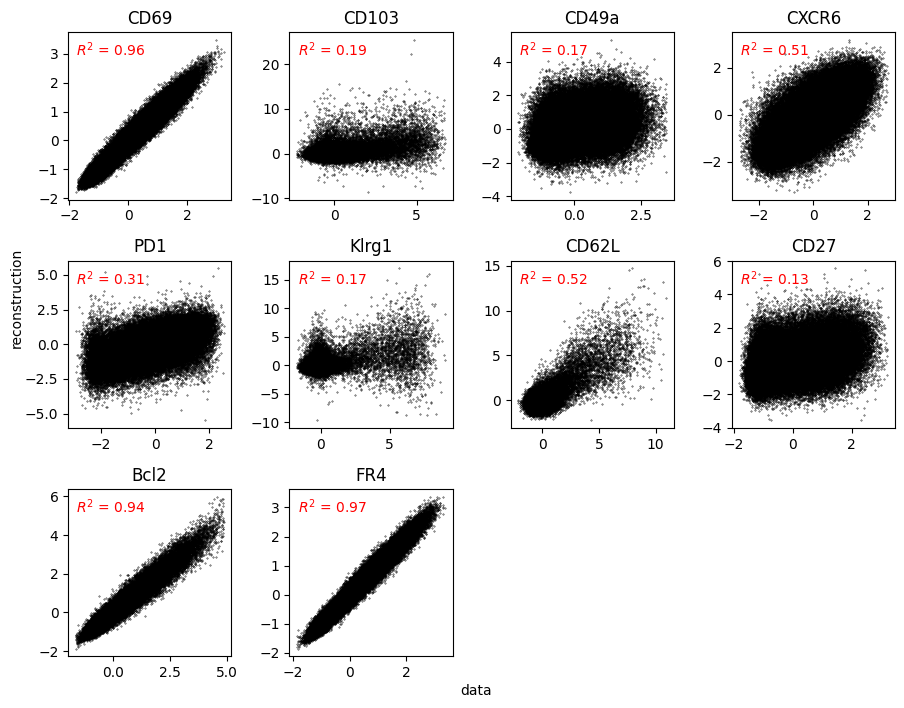

In [41]:
## Checkout reconstruction

tensor_recon = vae.reconstruct_sample(tensor_data, tensor_times, tensor_batch_onehot)
raw_recon = tensor_recon.cpu().detach().numpy()
R2s_recon = []

fig, axs = plt.subplots(3, 4, figsize=(9,7))

for i in range(feature_dim):
    ax = axs.flatten()[i]
    ax.scatter(raw_data[:,i], raw_recon[:,i], s=0.1, color='k')
    r, p = sts.pearsonr(raw_data[:,i], raw_recon[:,i])
    R2 = r**2
    R2s_recon.append(R2)
    ax.set_title(sel_markers[i])
    ax.text(
        0.05, 0.95, 
        f"$R^2$ = {R2:0.2f}", 
        transform=ax.transAxes,
        va='top', ha='left',
        color='r'
    )

for i, ax in enumerate(axs.flatten()):
    if i >= feature_dim:
        ax.axis('off')
    
fig.text(0.5, 0.0, "data")
fig.text(0.0, 0.5, "reconstruction", rotation=90)

fig.tight_layout()

## Finally, we want to simulate marker expression and compare marginal distributions.

We use the generative aspect of the model to simulate single-cell flow cytometry data.
At simulation time points, simulate latent vectors by sampling from the GMM.
Then map the $z$-values to $x$-values in the feature space.

In [42]:
## simulate marker expression on sampling days

marker_expression_sim = []
num_sams = 5000
for i, t in enumerate(unique_sample_day):
    print(f"sampling day: {t}")
    t_shifted = t - T0
    t_tensor = torch.tensor([t_shifted], device=vae.device, dtype=torch.float32)
    # select only those individuals at the current sample day
    tens_batch = tensor_batch_onehot[xtime_index_tensor==i]
    p = torch.ones(tens_batch.shape[0])
    idx = p.multinomial(num_sams, replacement=True)
    s = tens_batch[idx,:]
    zz, xx, clus_vec = vae.posterior_sample(t_tensor, s, n=num_sams)
    xx_raw = xx.squeeze().cpu().detach().numpy()

    marker_expression_sim.append(xx_raw)

## also create a data set for the true data...

marker_expression_data = []
for t in unique_sample_day:
    xs = raw_data[sample_day==t, :]
    marker_expression_data.append(xs)

sampling day: 8.0
sampling day: 12.0
sampling day: 16.0
sampling day: 20.0
sampling day: 24.0
sampling day: 28.0
sampling day: 37.0
sampling day: 57.0


### Plot the observed data and the simulated data in the same plot

Data is shown in **black**, <span style="color:red">simulations are shown in **red**</span>.

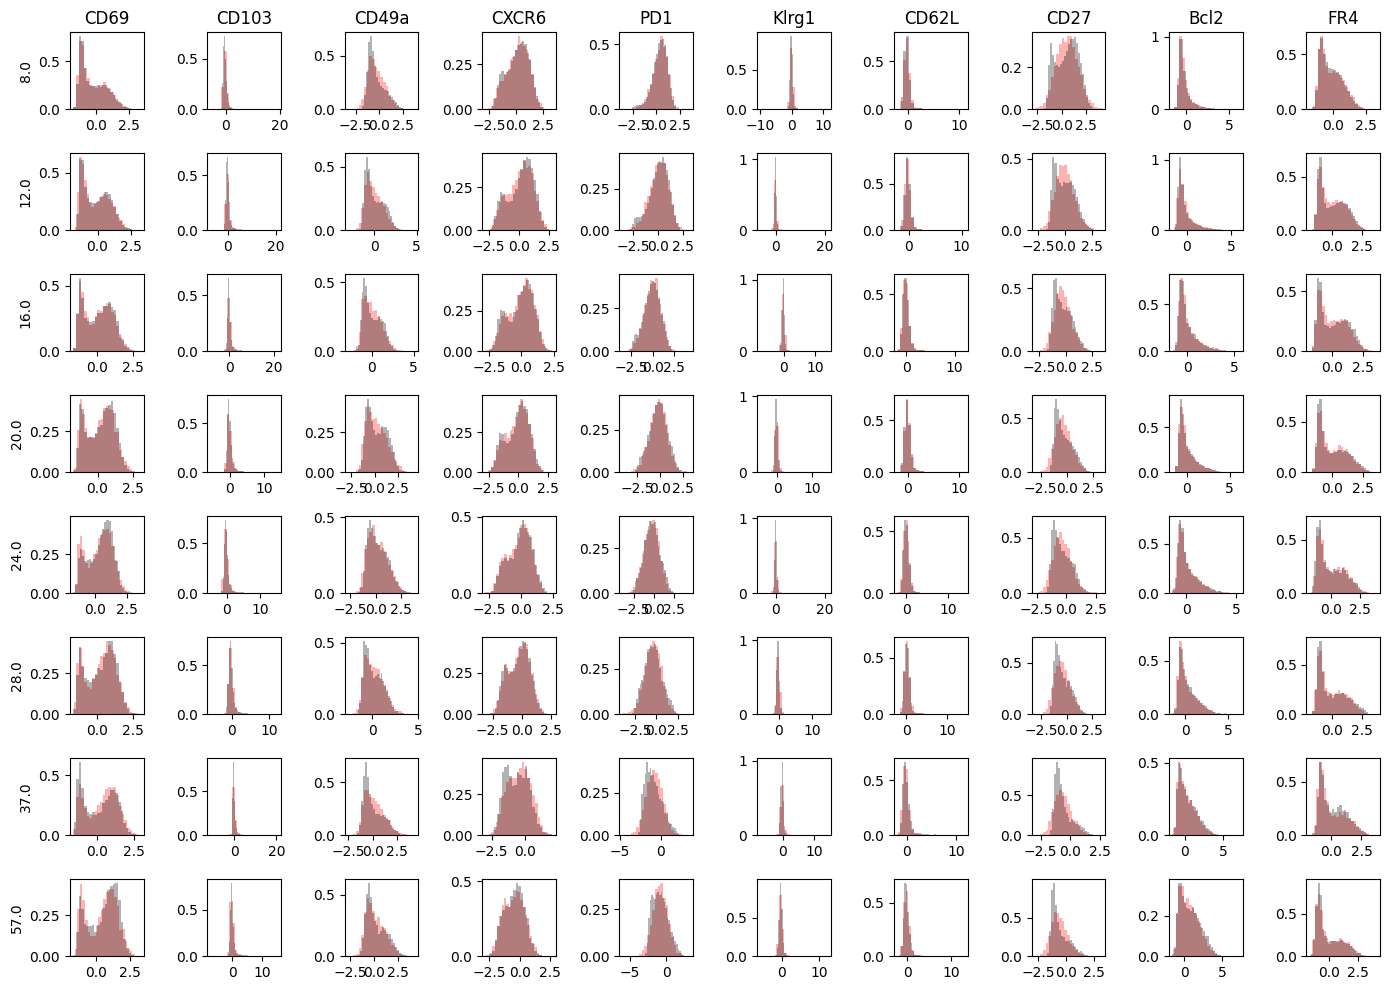

In [43]:
fig, axs = plt.subplots(len(unique_sample_day), len(sel_markers), figsize=(14,10))

for i, t in enumerate(unique_sample_day):
    for j, m in enumerate(sel_markers):
        ax = axs[i,j]
        xs = marker_expression_sim[i][:,j]
        ys = marker_expression_data[i][:,j]
        ax.hist(xs, 25, density=True, alpha=0.3, color='r')
        ax.hist(ys, 25, density=True, alpha=0.3, color='k')
        if j == 0:
            ax.set_ylabel(t)
        if i == 0:
            ax.set_title(m)

fig.tight_layout()

### Save data for making a validation figure for the IA

In [44]:
data_figure_IA_validate = {
    "idxs_mix" : idxs_mix,
    "flat_umap_samples" : flat_umap_samples,
    "umap_samples_sim" : umap_samples_sim,
    "umap_samples_data" : umap_samples_data,
    "densities_per_frame_sim" : densities_per_frame_sim,
    "densities_per_frame_data" : densities_per_frame_data,
    "clus_sorted_by_size" : clus_sorted_by_size,
    "transformed_samples_per_clus" : transformed_samples_per_clus,
    "marker_expression_sim" : marker_expression_sim,
    "marker_expression_data" : marker_expression_data,
    "raw_data" : raw_data,
    "raw_recon" : raw_recon,
    "R2s_recon" : R2s_recon,
    "sel_markers" : sel_markers,
    "unique_sampling_day" : unique_sample_day,
}

with open("../results/data_IA_validation_CD4.pkl", 'wb') as f:
    pickle.dump(data_figure_IA_validate, f)